# Differential Expression Analysis of Unnanotated Genes in the BrainSpan Dataset  
This notebook details the analysis performed on the BrainSpan RNA-Seq dataset. These data were processed including previously unannotated genes, provided in the c data folder, and so are the focus of study. 

## Set-up

In [1]:
R.version

               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          1.2                         
year           2021                        
month          11                          
day            01                          
svn rev        81115                       
language       R                           
version.string R version 4.1.2 (2021-11-01)
nickname       Bird Hippie                 

### Libraries

In [2]:
library(GGally)
library(dplyr)
library(stats)
library(edgeR)
library(reshape2)
library(ggplot2)
library(reshape)
library(nlme)
library(readr)
library(data.table)
library(ComplexHeatmap)
library(RColorBrewer)
library(repr)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: limma


Attaching package: ‘reshape’


The following objects are masked from ‘package:reshape2’:

    colsplit, melt, recast


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse



Attaching package: ‘data.table’


The following object is masked from ‘package:reshape’:

    melt


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.or

### Directories

In [3]:
# Define working directories
# wd <- "~/../denovobs/"
wd <- "~/codebases/denovobs/"
# wd <- "/mnt/c/Users/xoelm/denovobs/"
setwd(wd)

outfolder_plots <- paste0(wd, 'plots/')
dir.create(outfolder_plots, showWarnings = F)

outfolder_results <- paste0(wd, 'results/')
dir.create(outfolder_results, showWarnings = F)

### Parameters

In [4]:
options(repr.plot.width=25, repr.plot.height=10)
ht_opt$message <- FALSE

In [5]:
# Parameters to iterate
norm.method.opts <- c('rpkm', 'tpm', 'log2_tpm')
eras.opt <- c('Primate', 'Human')
min.samples.opt <- c('one_or_more', 'ten_percent')
thresholds <- list(rpkm=c(0.3, 1, 2), tpm=c(0.002), log2_tpm=c(0.003))
group.var.opt <- c('area', 'Region')

In [6]:
# Colors for plotting
colors.eras <- setNames(c("#D53E4F", "#FC8D59", "#FEE08B", "#E6F598", "#99D594", "#3288BD"),
                        c('Ancient', 'Animal', 'Chordate','Mammal', 'Primate',  'Human'))
colors.Annotated <- setNames(c("#EF8A62", "#67A9CF"), c('Not annotated', 'Annotated'))
colors.hs <- setNames(c("#F29E4C", "#16DB93"), c("Not human specific","Human specific"))
colors.bool <- setNames(c("darkgreen", "lightgrey"), c('YES', 'NO'))
colors.top <- setNames(c("darkgreen", "lightgrey"), c('TRUE', 'FALSE'))
colors.all <- c(colors.eras, colors.Annotated, colors.bool, colors.hs)

gene.annot.colors <- list('Annotated'=colors.Annotated,
                          'Eras'=colors.eras, 
                          'Annotated'=colors.Annotated,
                          'topsd'=setNames(c("black", "lightgrey"), c('TRUE', 'FALSE')),
                          'topmean'=setNames(c("black", "lightgrey"), c('TRUE', 'FALSE')), 
                          'min.samples'=setNames(c("darkgrey", "lightgrey"), c('TRUE', 'FALSE')),
                          'Regional'=setNames(c("gold", "darkgrey"), c('YES', 'NO')),
                          'Temporal'=setNames(c("lightgreen", "darkgrey"), c('YES', 'NO')))

In [7]:
# Columns to annotate genes in heatmaps
gene.annot.cols.raw <- c('Eras', 'Annotated')
gene.annot.cols.norm <- c('Eras', 'Annotated')
gene.annot.cols.eras <- c('Eras', 'Annotated', 'topsd', 'topmean')
gene.annot.cols.thres <- c('Eras', 'Annotated', 'topsd', 'topmean', 'min.samples')
gene.annot.cols.exp <- c('Eras', 'Annotated', 'topsd', 'topmean', 
                         'Regional', 'Temporal')

# Columns to divide count density plots
plot.density.col.opts <- c('Eras', 'Annotated')

In [8]:
# Load results if already computed
load.results.opt <- T

# Plot format
plot.format.opt <- 'pdf'
# Create legnth comparison, initial count density plots and heatmaps.
initial.plots.opt <- F
# Create length comparison plots
length.plots.opt <- F
# Create count density plots
count.density.opt <- F
# Create heatmaps
heatmap.opt <- F
# Create summary plots
summary.plots.opt <- T

# Postpone heatmap saving 
delayed.opt <- T # Creates a rds file enough to visualize and export the heatmap. Otherwise, save on the fly
run.now.opt <- F # Run the delayed saving now asynchronously (don't wait to finish, separate process)
# Script for postpone saving and register queue
save_htmp.delay.script <- paste0(wd, 'delayed.save_htmp.R')
which.rscript <- 'Rscript' #'"C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe"'

## Data
  

We need to load several tables:  
- *Counts*: expression data from BrainSpan, mapped to Hs_Ens89+2102_PS_seq_etc_hg38  
- *Sample metadata*: includes sample demographic features, QC, ids...  
- *Gene lengths*: loads the GFF file used to map the expression data to compute the gene length  
- *Gene metadata*: includes information about the phylostratum, coordinates, annotation state...

### BrainSpan counts

We have expression data from 607 samples mapped to the ```Hs_Ens89+2102_PS_seq_etc_hg38``` genome annotation, one file per sample, in the folder ```data/COUNTS_DEC2021/```.  We save the data in one file since it takes a bit to reload them.

In [9]:
# If the counts have been already processed, just load them:
if (file.exists(paste0(wd, 'data/counts.2021.csv'))){

    denovo <- read.csv(paste0(wd, 'data/counts.2021.csv'), row.names = 1)

} else {
    
    # List files of counts
    files <- dir("data/COUNTS_DEC2021/")
    
    # Iterate and load each file
    denovo <- c()
    sample.names <- c()
    for ( f in files ) {
        temp <- read.table(paste0(wd, "data/COUNTS_DEC2021/",f), fill = TRUE, sep="\t") # load
        temp <- temp[ -grep("^__", temp$V1) ] # This deletes check rows
        denovo <- cbind(denovo, temp[,2]) # Append 
        sample.names <- c(sample.names, paste(strsplit(f, '.', fixed=T)[[1]][1:2], collapse="."))  # set name of sample
    }
  
    rownames(denovo) <- temp$V1  # set gene names
    colnames(denovo) <- sample.names  # set sample names

    denovo <- denovo[-grep("__", rownames(denovo)), ] # This deletes check rows

    # Save file
    write.csv(denovo, 'data/counts.2021.csv', row.names=T) 
}


In [10]:
head(denovo)

,HSB103.A1C,HSB103.AMY,HSB103.CBC,HSB103.DFC,HSB103.HIP,HSB103.IPC,HSB103.ITC,HSB103.M1C,HSB103.MFC,HSB103.OFC,⋯,HSB98.DFC,HSB98.HIP,HSB98.IPC,HSB98.MD,HSB98.MFC,HSB98.MSC,HSB98.STC,HSB98.STR,HSB98.V1C,HSB98.VFC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Baz_Hs_103_nt,45,44,42,36,26,31,32,29,30,26,⋯,60,67,23,64,65,25,28,62,29,47
Baz_Hs_108_nt,13,62,129,13,19,12,15,11,53,36,⋯,12,95,21,252,27,16,21,86,13,10
Baz_Hs_10_nt,959,473,438,1345,518,746,484,1145,1239,1200,⋯,911,484,823,531,906,757,1067,774,780,934
Baz_Hs_112_nt,176,165,158,159,123,171,136,143,188,159,⋯,156,133,44,78,94,41,92,142,25,119
Baz_Hs_113_nt,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Baz_Hs_114_nt,0,0,0,0,0,1,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0


### BrainSpan metadata  
We load the metadata from the ```data/sample_metadata.csv``` and group all the neocortical regions (11) under the region neocortex. The 16 regions and the 6 areas are used for the grouping of the samples in the differential expression (DE) test and the expression heatmaps.

In [11]:
# Define regions to study
temporal<-c("A1C","STC","ITC")
frontal<-c("OFC","DFC","MFC","M1C","VFC")
parietal<-c("S1C","IPC")
occipital<-c("V1C")
subcortex<-c("HIP", "AMY", "STR", "MD")	

cortex<-c(frontal, parietal, temporal, occipital)
all.regions <-c(cortex, subcortex, "CBC")
group_order <- list(area=c('NCX','HIP','AMY','STR','MD','CBC'),
                    Region=all.regions)

In [12]:
# Load data
sample_meta <- read.csv(paste0(wd,'data/sample_metadata.csv'))
row.names(sample_meta) <- sample_meta$Sample # set index
sample_meta$Braincode <- sapply( strsplit( as.character( sample_meta$Sample ), split=".", fixed=T ),"[", 1 ) # set donor id

# Create area grouping
sample_meta$area <- as.character(sample_meta$Region)
sample_meta$area[sample_meta$Region %in% cortex] <- 'NCX'

In [13]:
head(sample_meta)

,Sample,Window,Hemisphere,Age,Days,Sex,Ethnicity,PMI,pH,RIN,⋯,temporal_3,temporal_4,temporal_5,spatial_0,spatial_1,spatial_2,spatial_3,spatial_4,Braincode,area
,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
HSB103.A1C,HSB103.A1C,2,R,13PCW,91,M,European,1.5,NA,9.3,⋯,EARLY MID FETAL,FETAL,PRENATAL,1 AUDIT C,1 AUDIT C,TEMPORAL,NEOCORTEX,CEREBRUM,HSB103,NCX
HSB103.AMY,HSB103.AMY,2,R,13PCW,91,M,European,1.5,NA,9.3,⋯,EARLY MID FETAL,FETAL,PRENATAL,AMYGDALA,AMYGDALA,AMYGDALA,AMYGDALA,CEREBRUM,HSB103,AMY
HSB103.CBC,HSB103.CBC,2,R,13PCW,91,M,European,1.5,NA,9.3,⋯,EARLY MID FETAL,FETAL,PRENATAL,CEREBELLAR C,CEREBELLAR C,CEREBELLAR C,CEREBELLAR C,CEREBELLAR C,HSB103,CBC
HSB103.DFC,HSB103.DFC,2,R,13PCW,91,M,European,1.5,NA,9.3,⋯,EARLY MID FETAL,FETAL,PRENATAL,DORSOLAT PFC,PREFRONTAL C,FRONTAL,NEOCORTEX,CEREBRUM,HSB103,NCX
HSB103.HIP,HSB103.HIP,2,R,13PCW,91,M,European,1.5,NA,9.3,⋯,EARLY MID FETAL,FETAL,PRENATAL,HIPPOCAMPUS,HIPPOCAMPUS,HIPPOCAMPUS,HIPPOCAMPUS,CEREBRUM,HSB103,HIP
HSB103.IPC,HSB103.IPC,2,R,13PCW,91,M,European,1.5,NA,9.3,⋯,EARLY MID FETAL,FETAL,PRENATAL,POST INF PAR C,POST INF PAR C,PARIETAL,NEOCORTEX,CEREBRUM,HSB103,NCX


#### CHECK 1 - Age distribution

Plot the distribution of ages of donors and samples. **We have samples starting in the 8 PCW up to 40 year of age.**

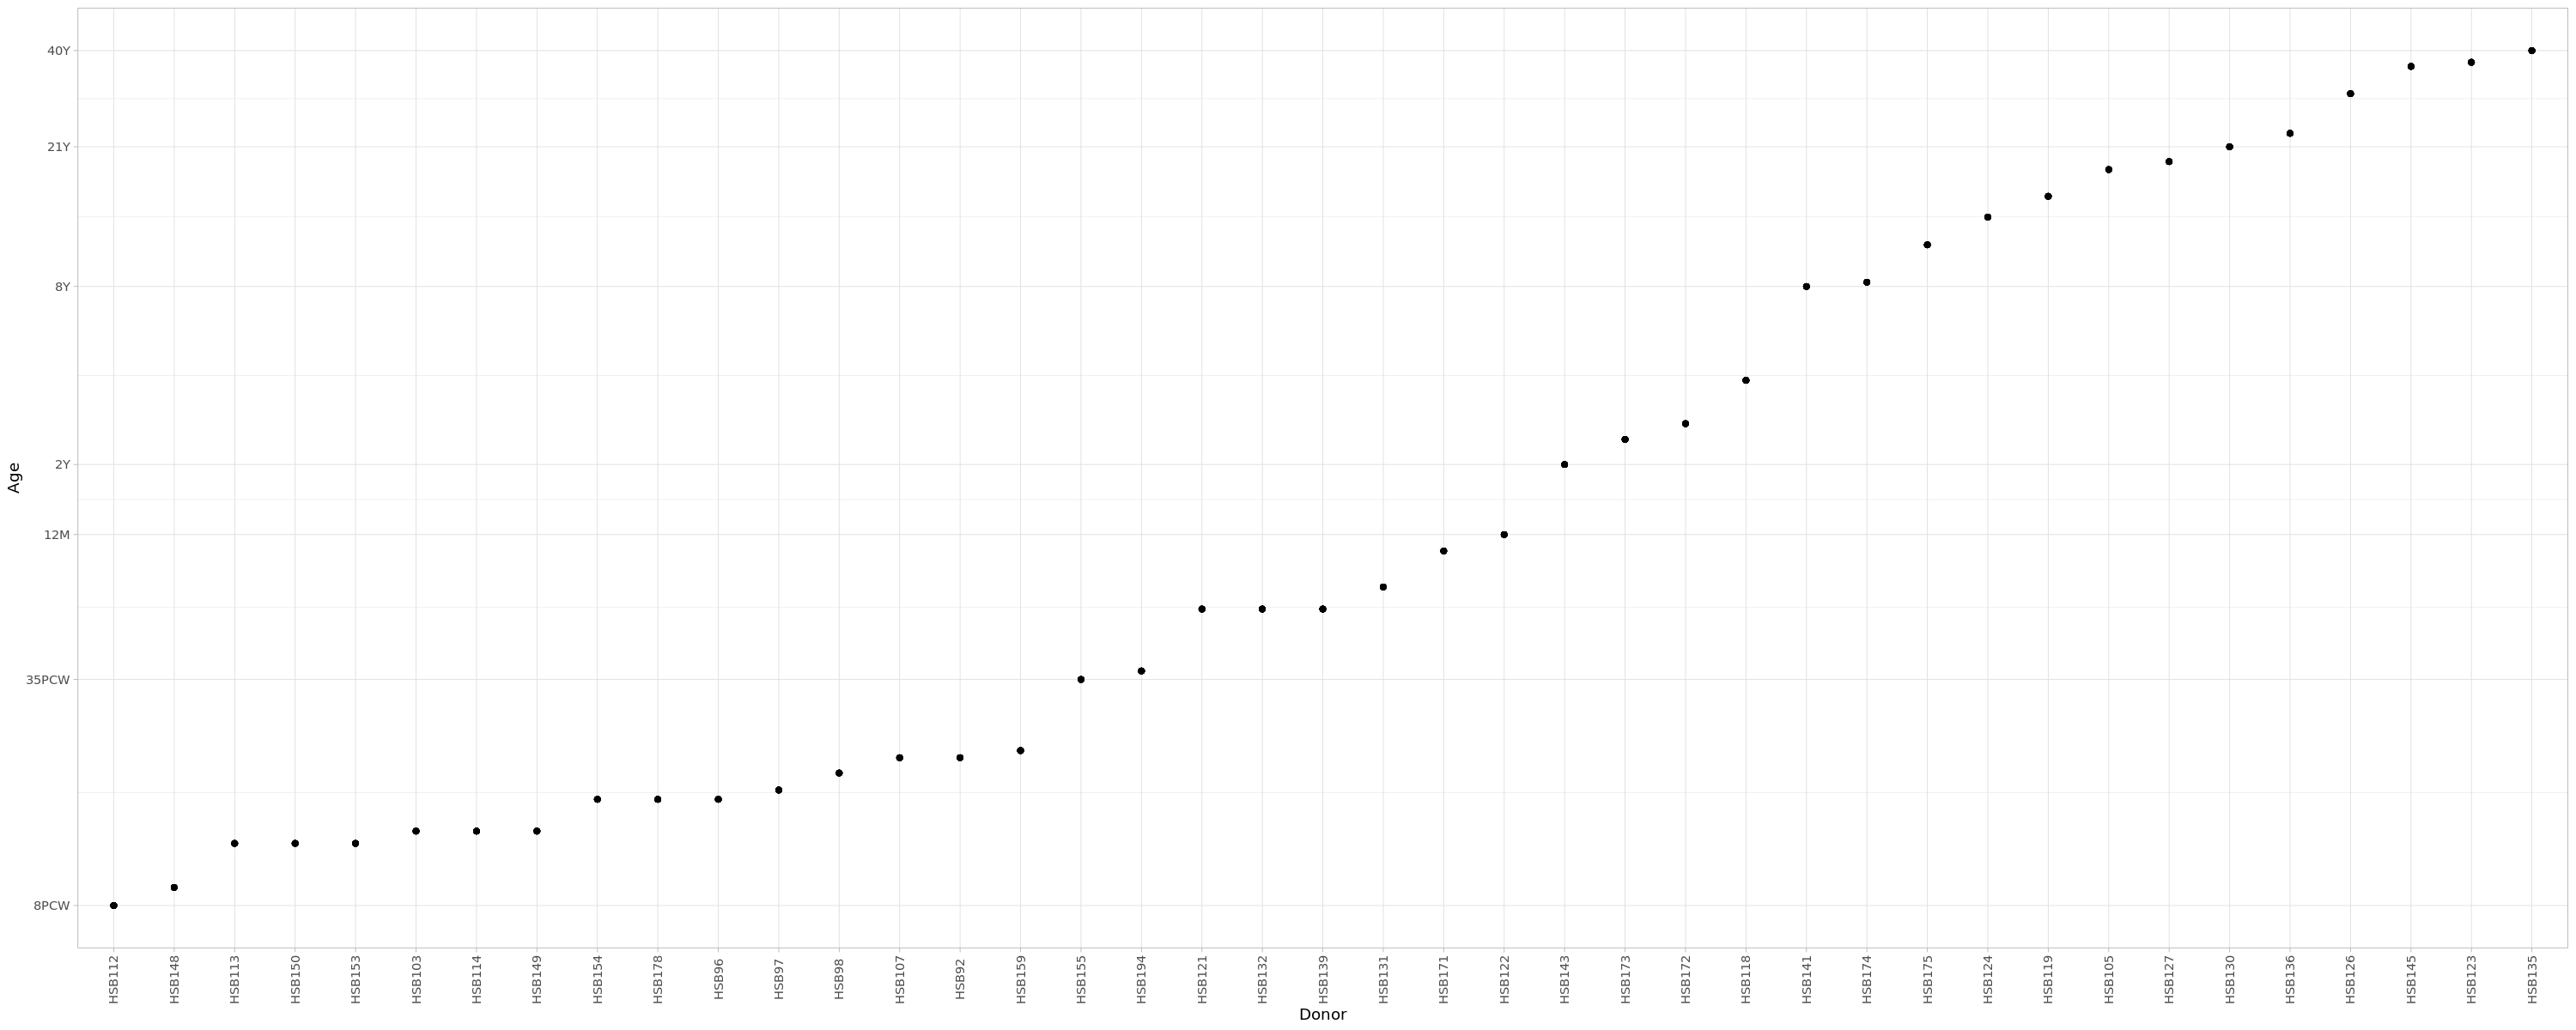

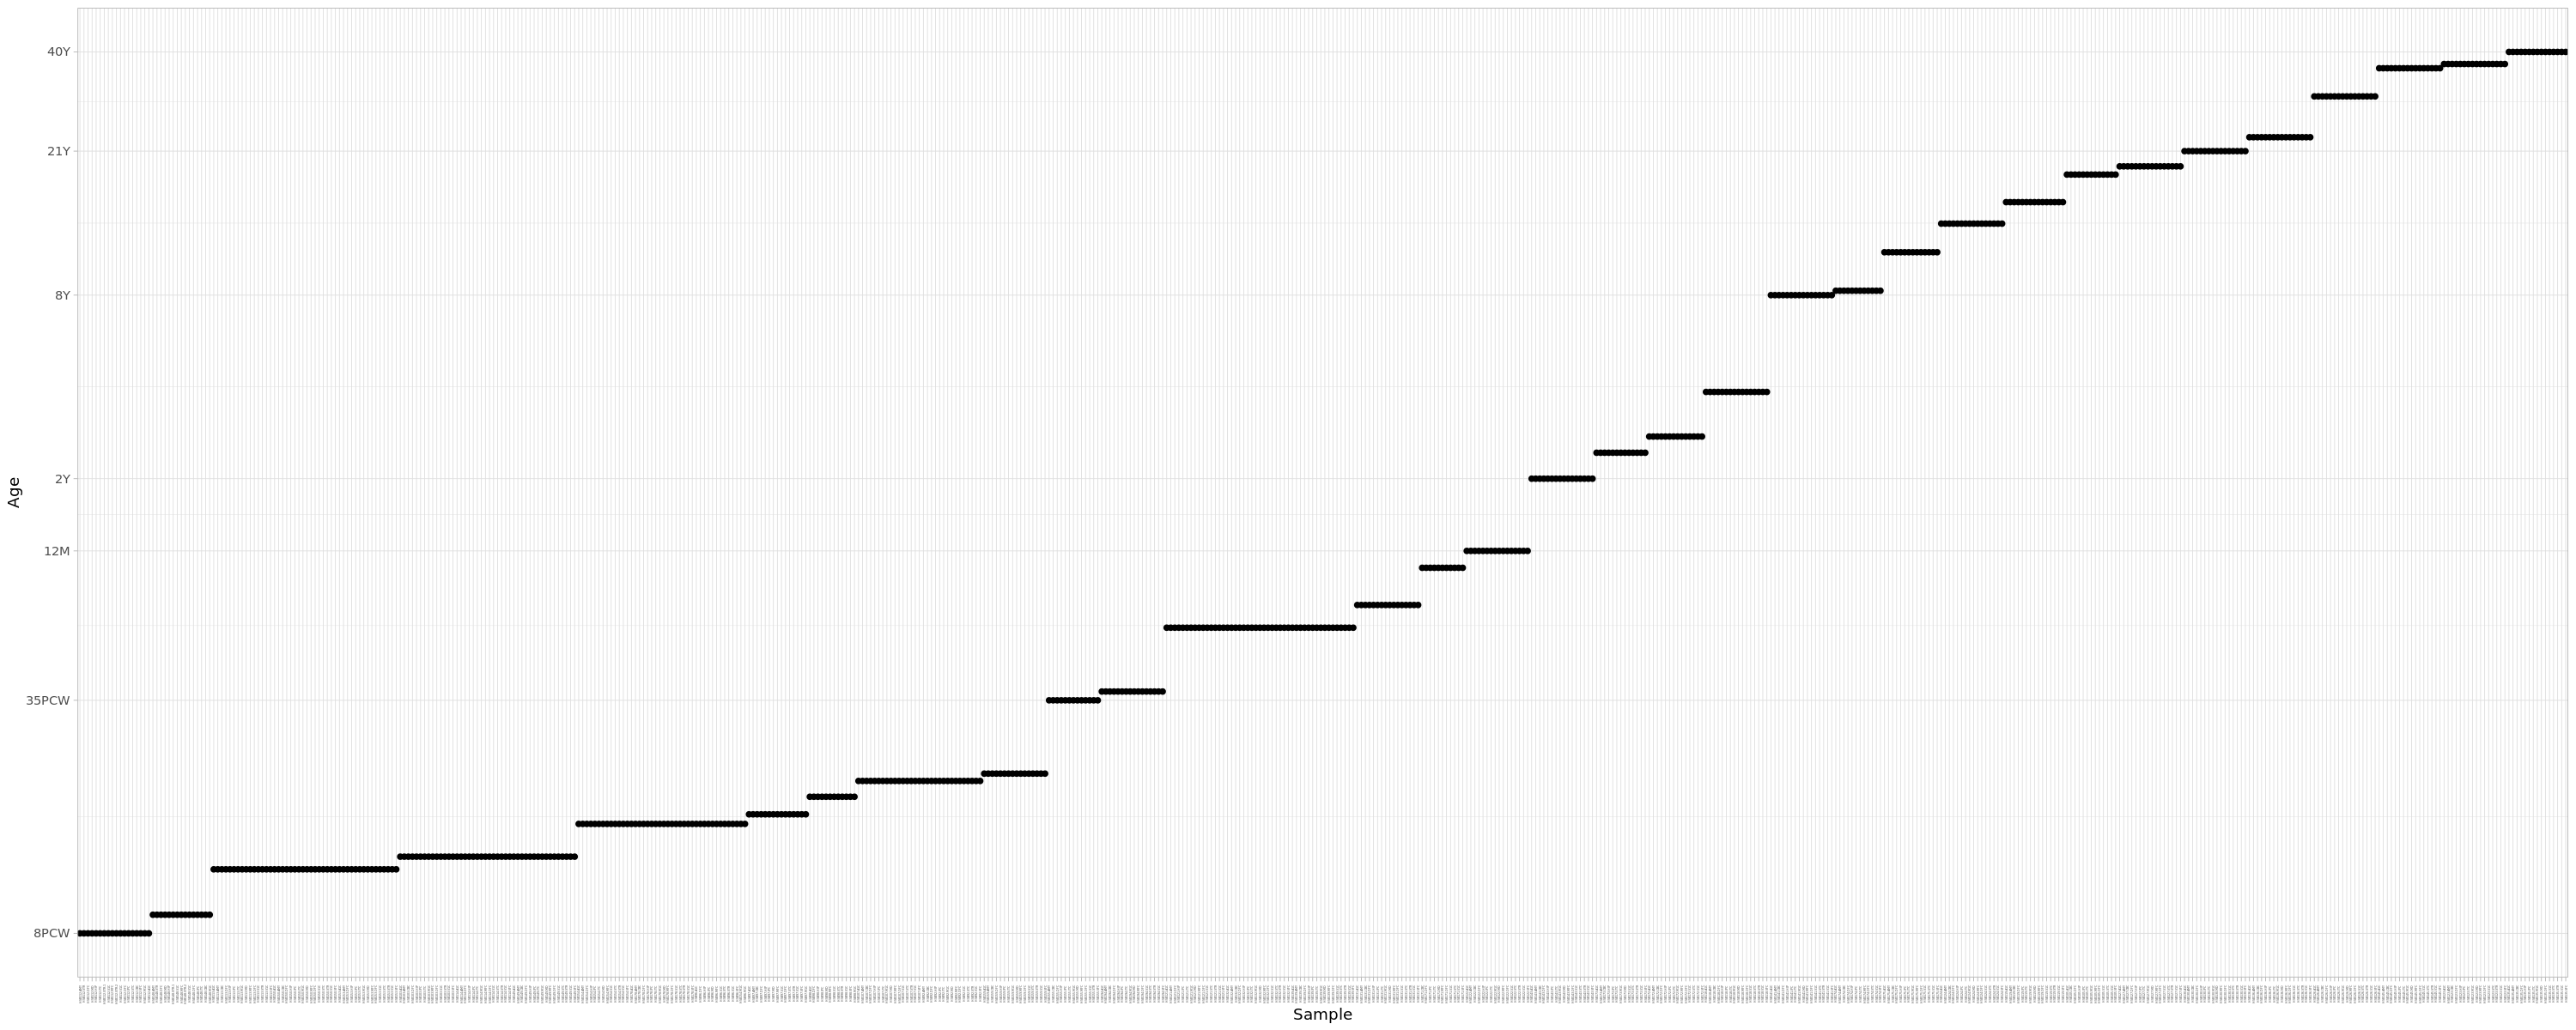

In [14]:
# Per donor
donor.age.plot <- ggplot(sample_meta[order(sample_meta$Days),]) +
  geom_point(aes(x=factor(Braincode, levels=unique(Braincode)), y=Days)) +
  scale_y_log10(breaks = c(56, 245, 631, 997, 3188, 7936, 14876),
                labels = c('8PCW','35PCW', '12M', '2Y', '8Y', '21Y', '40Y')) +
  theme_light() + 
  theme(axis.text.x = element_text(angle=90, vjust=0.5)) + xlab('Donor') + ylab('Age')
donor.age.plot

# Per sample
sample.age.plot <- ggplot(sample_meta[order(sample_meta$Days),]) +
  geom_point(aes(x=factor(Sample, levels=unique(Sample)), y=Days)) +
  scale_y_log10(breaks = c(56, 245, 631, 997, 3188, 7936, 14876),
                labels = c('8PCW','35PCW', '12M', '2Y', '8Y', '21Y', '40Y')) + 
  theme_light() + 
  theme(axis.text.x = element_text(size=2, angle=90, vjust=0.5)) + xlab('Sample') + ylab('Age')
sample.age.plot

### Gene lengths (GFF)  
We need the length of the genes for the normalization step. To compute them, we use the genome annotation to retrieve the length of the joint CDS (and, for comparison, exons) per gene, using bedtools. We save the data since it takes a bit to recompute them.

In [15]:
# Load the lengths if they have been already computed 
if (file.exists(paste0(wd, 'data/geneLengthGFF.csv'))){
    
    geneInfo <- read.csv(paste0(wd, 'data/geneLengthGFF.csv'))

} else {
    
    # Load coordinates
    coordsGFF <- fread(paste0(wd,"data/Hs_Ens89+2102_PS_seq_etc_hg38/GTF_GENEPRED/Hs_Ens89+2102_1iso_hg38.ANNOTATION.txt"), header=T, sep='\t')#, nrows=1000)
    colnames(coordsGFF)[seq(1:9)] <- c('chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'info')

    # Get gene names from info
    coordsGFF[,'GeneID'] <- sapply(strsplit(sapply(coordsGFF[,'info'], as.character),"\""), `[`, 2)
    # Fix coordinates
    coordsGFF[,'start'] <- sapply(coordsGFF[,'start'], as.integer)-1
    coordsGFF[,'end'] <- sapply(coordsGFF[,'end'], as.integer)

    # Retrive merge-of-exons length
    el <- sapply(unique(coordsGFF$GeneID), FUN=function(i){
        coords.m <- filter(coordsGFF, GeneID ==i, feature=='exon')
        str_bed <- format_delim(coords.m[,c('chr', 'start', 'end')], delim='\t', col_names = FALSE)
        mer_bed <- read.csv(text=system(paste0('printf \'', str_bed,'\' | sort -k 1,1 -k2,2n | bedtools merge'), intern=T), header=F, sep='\t', col.names = c('chr', 'start', 'end'))
        GeneLength <- sum( mer_bed$end - mer_bed$start  )

        return(GeneLength)
    })

    # Retrive merge-of-CDS length
    cdsl <- sapply(unique(coordsGFF$GeneID), FUN=function(i){
        coords.m <- filter(coordsGFF, GeneID ==i, feature=='CDS')
        str_bed <- format_delim(coords.m[,c('chr', 'start', 'end')], delim='\t', col_names = FALSE)
        mer_bed <- read.csv(text=system(paste0('printf \'', str_bed,'\' | sort -k 1,1 -k2,2n | bedtools merge'), intern=T), header=F, sep='\t', col.names = c('chr', 'start', 'end'))
        GeneLength <- sum( mer_bed$end - mer_bed$start  )

        return(GeneLength)
    })

    # Create data.frame of lengths
    geneInfo <- data.frame(ID=names(el), exon_merge=el, CDS_merge=cdsl)

    # Save lengths
    write.csv(geneInfo, file=paste0(wd, 'data/geneLengthGFF.csv'), row.names = F)

}

In [16]:
head(geneInfo)

,ID,exon_merge,CDS_merge
,<chr>,<int>,<int>
1,ENSP00000000233_nt,1103,540
2,ENSP00000000412_nt,2756,831
3,ENSP00000000442_nt,2215,1269
4,ENSP00000001008_nt,3732,1377
5,ENSP00000001146_nt,4732,1536
6,ENSP00000002125_nt,2176,1323


### Gene annotation
The gene annotation contains information about the phylostratum, genomic coordinates, protein and coding sequences. We'll use it in several parts of the analysis and add some information to it.

In [17]:
# Load annotation
complete <- fread(paste0(wd, 'data/Hs_Ens89+2102_PS_seq_etc_hg38/Hs_Ens89+2102_PS_seq_etc_hg38.txt'),
                  header=T, sep='\t')
head(complete)

Protein_ID,PS,Name,Description,Plength,Gap_Gene?,Chr,Gene_Start_hg38,Gene_End_hg38,Strand,CDS_Start_hg38,CDS_End_hg38,Protein_Sequence,CDS_Sequence
<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
Baz_Hs_1,31,,ENST00000308604.5_18272_457,52,Not_Gap_Gene,chr2,N/A,N/A,-,111429413,111429572,MTDTENHDSSPSSTSTCCPPITAGMQLKDSLGPGSNCPLWTLRPLHLRVVCL,ATGACAGACACTGAAAATCACGACTCATCCCCCTCCAGCACCTCTACCTGTTGCCCGCCGATCACAGCCGGAATGCAGCTGAAAGATTCCCTGGGGCCTGGTTCCAACTGCCCACTGTGGACTCTGAGGCCTCTGCATTTGCGGGTGGTCTGCCTGTGA
Baz_Hs_10,31,,ENST00000411630.2_23991_594,59,Not_Gap_Gene,chr4,N/A,N/A,+,52713673,52713853,MLVATGQCSRCFMFTFSTFSFNCHNSEVDSVRDRLPQDHSAPANSMQLTLTLNTLQLHS,ATGCTGGTGGCAACAGGGCAGTGTAGCAGGTGCTTCATGTTCACCTTTTCAACCTTTTCATTTAATTGTCACAACTCGGAGGTGGATTCTGTTAGGGACAGGCTGCCCCAGGACCACTCCGCCCCCGCTAACTCAATGCAGCTGACCCTTACCCTGAATACTCTGCAGCTGCATTCCTGA
Baz_Hs_103,31,,ENST00000499346.2_27384_333,84,Not_Gap_Gene,chr5,N/A,N/A,-,128082767,128083022,MLGAFRSGPQPLPEPRARCVPQPGLLWALTRRRESPLVTPGLNLEEGGFPLCSFRAVDSPCQADLDWHNQRSVPVVMQWVSTHF,ATGCTGGGGGCTTTCCGGTCGGGGCCGCAGCCGCTTCCGGAGCCGCGGGCGAGGTGCGTTCCCCAGCCTGGTTTGCTCTGGGCTCTGACCCGCCGCCGCGAATCTCCGCTCGTAACTCCGGGCCTGAACCTGGAGGAGGGAGGATTTCCTCTGTGCAGCTTTCGAGCGGTAGACTCACCCTGCCAGGCAGACCTAGATTGGCATAACCAGAGATCAGTTCCAGTTGTGATGCAGTGGGTGTCTACACACTTCTGA
Baz_Hs_108,24,,ENST00000501177.3_12701_390,84,Not_Gap_Gene,chr16,N/A,N/A,-,54919086,54925136,MLAEIHPKAGLQSLQFIMELLYWLLEGGDSEDKEDATGNVEMKNIQPLVFEISCDVFQSRCKEHGKIKVLEWFKYVLGIPVYRL,ATGTTGGCTGAAATTCATCCCAAGGCTGGTCTGCAAAGTCTGCAATTCATAATGGAGCTACTGTACTGGCTATTGGAAGGAGGAGATTCTGAAGATAAGGAGGATGCCACTGGAAATGTTGAAATGAAAAATATTCAGCCGTTGGTCTTTGAAATTTCCTGTGATGTGTTTCAATCTAGATGCAAAGAACATGGAAAAATCAAAGTGCTCGAGTGGTTTAAATATGTTTTGGGTATTCCTGTTTATAGACTATAA
Baz_Hs_112,25,,ENST00000503704.1_24073_293,52,Not_Gap_Gene,chr4,N/A,N/A,-,82900166,82900435,MRSREAGPKLRRIQEPANGSPGAVSETGGYREERLSDAEIMGKLLAWLAVGM,ATGCGAAGCAGAGAGGCAGGACCAAAATTGAGGCGAATCCAGGAACCTGCCAATGGGTCTCCGGGTGCGGTCTCTGAAACTGGAGGATATCGGGAGGAAAGGCTCTCCGATGCGGAGATAATGGGGAAGCTCTTGGCATGGTTGGCTGTAGGTATGTGA
Baz_Hs_113,31,,ENST00000503797.2_26638_180,42,Not_Gap_Gene,chr5,N/A,N/A,-,170767378,170767507,MLLTQSLFGGLFTRTCMKFGAVTRIGGPPLGDQSPVLLLFAP,ATGTTGCTCACACAAAGCCTGTTTGGTGGTCTCTTCACACGGACATGCATGAAATTTGGTGCCGTGACTCGGATCGGGGGACCTCCCTTGGGAGATCAATCCCCTGTCCTCCTGCTCTTTGCTCCGTGA


In [18]:
# Ensure no duplicates
complete$Protein_ID[which(duplicated(complete$Protein_ID))] -> dups 
dups

# Check all genes in expression data are in the gene annotation
all(sapply(strsplit(rownames(denovo),"_nt"), `[`, 1) %in% complete$Protein_ID)

character(0)

[1] TRUE

We define the following eras according to the phylostratum:
- 1-3: Ancient  
- 4-7: Animal
- 8-17: Chordate  
- 18-22: Mammal
- 23-29: Primate
- 30-31: Human

In [19]:
# Define the eras according to phylostratum
complete$Eras <- factor(cut(complete$PS, 
                            breaks=c(0,3,7,17,22,29,31),
                            labels = c('Ancient', 'Animal', 'Chordate', 'Mammal', 'Primate', 'Human')))

# # Code for safety check
# complete$eras<-"Ancient"
# complete$eras[complete$PS %in% c(4:7)] <- "Animal"
# complete$eras[complete$PS %in% c(8:17)] <- "Chordate"
# complete$eras[complete$PS %in% c(18:22)] <- "Mammal"
# complete$eras[complete$PS %in% c(23:29)] <- "Primate"
# complete$eras[complete$PS %in% c(30:31)] <- "Human" 
# 
# complete$PS[complete$Eras !=complete$eras]

# Define human specific genes
complete$Human_specific <- ifelse(complete$Eras == 'Human', 'Human specific', 'Not human specific')

We'll define the gene symbol for the plots, and whether the gene is annotated or not.

In [20]:
# Define IDs 
complete$GeneID <- paste0(complete$Protein_ID, '_nt')

# Define gene symbol
complete$Gene.Symbol <- make.unique(ifelse((is.null(complete$Name) | complete$Name == ''),
                                           complete$Protein_ID, 
                                           complete$Name))

# Define annotated and Not annotated
complete$Annotated <- ifelse(grepl("ENS", complete$Protein_ID), 'Annotated', 'Not annotated')

Finally, we add the gene lengths to the annotation and define the one used for the normalization step. We used the ```CDS merge GFF``` length.

In [21]:
# Add  gene lengths
complete$`Exon merge GFF` <- geneInfo[match(complete$Protein_ID, 
                                            sapply(strsplit(geneInfo$ID,"_nt"), `[`, 1)),'exon_merge']
complete$`CDS merge GFF` <- geneInfo[match(complete$Protein_ID, 
                                           sapply(strsplit(geneInfo$ID,"_nt"), `[`, 1)),'CDS_merge']
complete$`Sequence length CDS` <- sapply(complete$CDS_Sequence,nchar)
complete$`Genomic coords (gene)` <- abs(as.numeric(complete$Gene_End_hg38)-as.numeric(complete$Gene_Start_hg38))
complete$`Genomic coords (CDS)` <- abs(as.numeric(complete$CDS_End_hg38)-as.numeric(complete$CDS_Start_hg38))


# Save gene lengths for normalization
gene_lengths <- complete[,c('GeneID','CDS merge GFF')]
colnames(gene_lengths) <- c('GeneID', 'Length')

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [22]:
# Convert in case it was data.table
complete <- as.data.frame(complete)
rownames(complete) <- complete$GeneID

#### CHECK 2 - Gene length

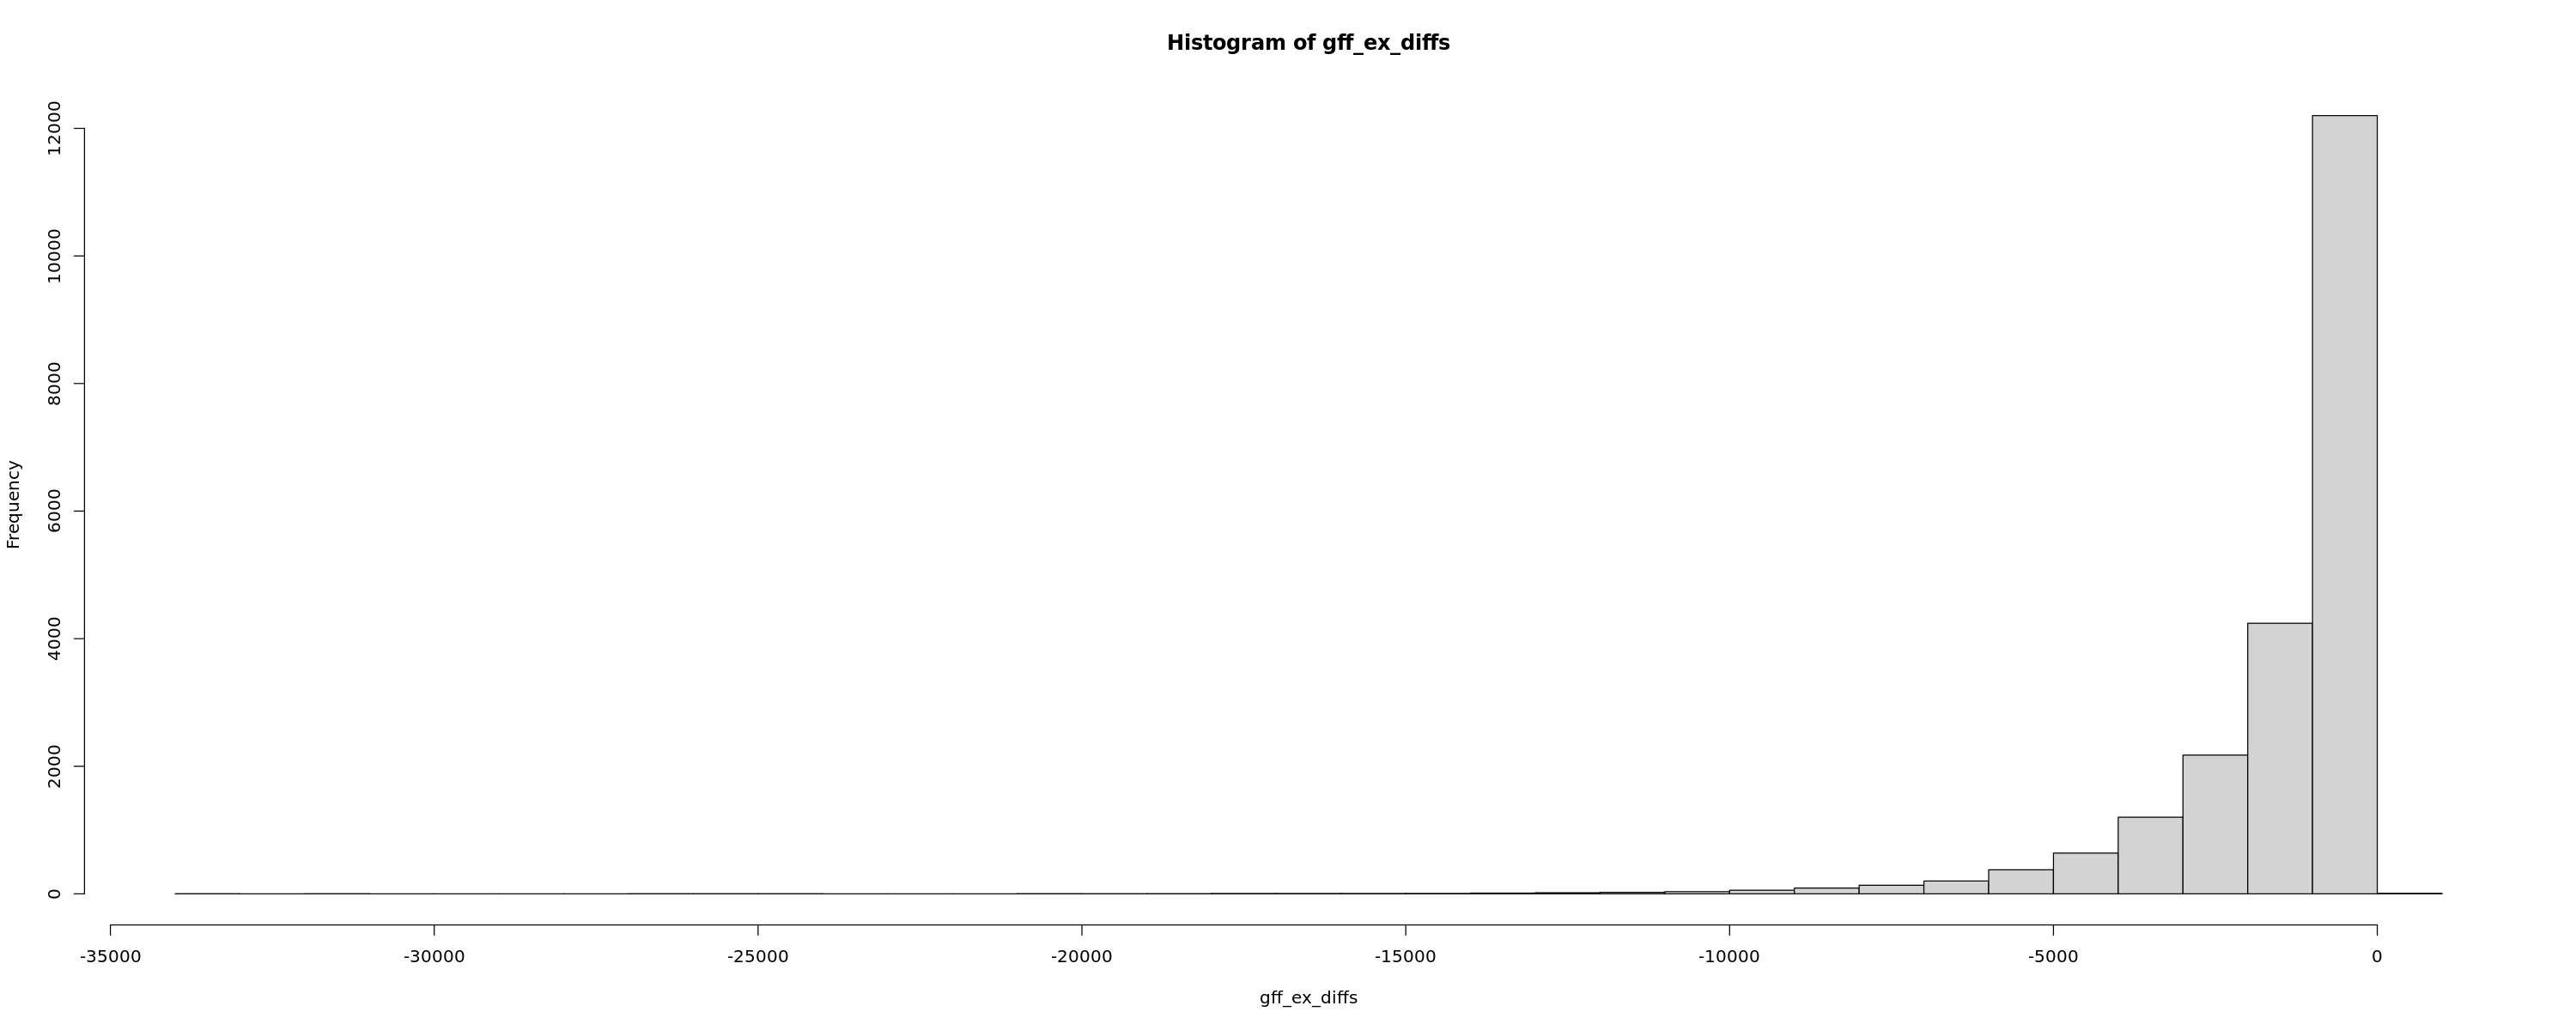

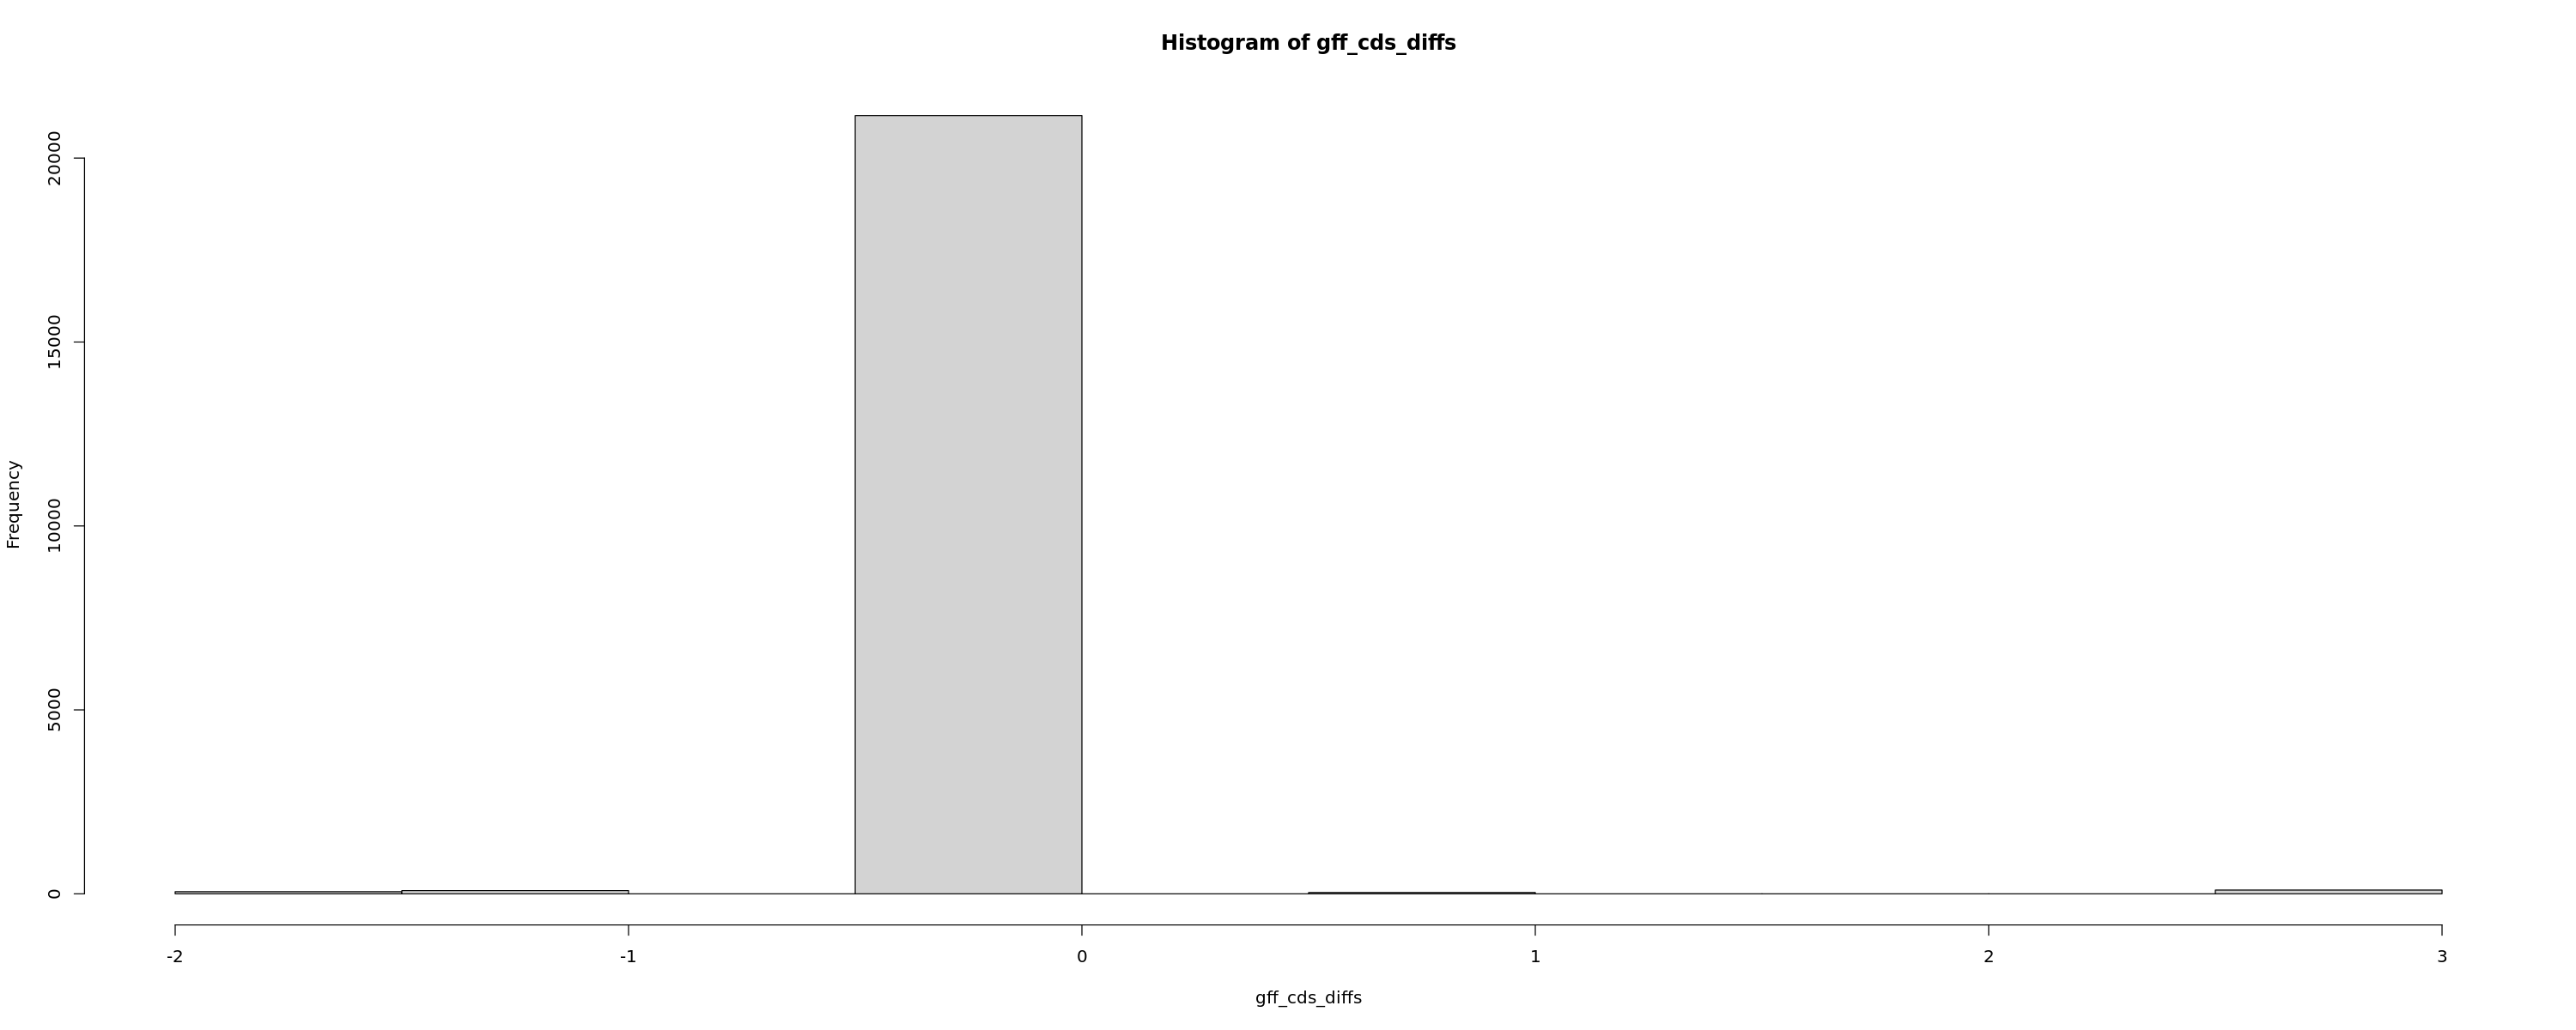

In [23]:
gff_ex_diffs <-sapply(complete$Protein_Sequence, nchar)*3 - complete$`Exon merge GFF`
hist(gff_ex_diffs, 30)

gff_cds_diffs <-sapply(complete$Protein_Sequence, nchar)*3 - complete$`CDS merge GFF`
hist(gff_cds_diffs)

## Functions

In this section, the functions to plot, process, save, test and summarize the data are created.

### Count density plot

This function is used to show the distribution of the counts in the data. The data can be colored and divided using the corresponding variables, and vertical lines can be added at specific thresholds.

In [24]:
count_density_plot <- function(exp.data, sample.meta, gene.annot,
                               fill.sample=NULL, fill.gene=NULL,
                               facet.sample=NULL, facet.gene=NULL,
                               thresholds=NULL, log10=TRUE, nrow=NULL, ncol=NULL,
                               path=NULL){

    # Check master switch for count density plots
    if (!count.density.opt){return()}

    # Wide-to-long data
    exp_long <- reshape2::melt(as.matrix(exp.data))

    # Retrieve sample annotation for facet and fill
    for (sample_col in c(fill.sample, facet.sample)){
        if (is.null(sample_col)) { next }
        exp_long[,sample_col] <- sample.meta[exp_long$Var2,sample_col]
    }

    # Retrieve gene annotation for facet and fill
    for (gene_col in c(fill.gene, facet.gene)){
        if (is.null(gene_col)) { next }
        exp_long[,gene_col] <- gene.annot[exp_long$Var1,gene_col]
    
        # We need to factor the eras just in case
        if (gene_col == 'Eras'){
            exp_long[,gene_col] <- factor(
                exp_long[,gene_col], 
                levels= c("Ancient","Animal","Chordate",
                           "Mammal","Primate", 'Human'),
                labels = c("Ancient","Animal","Chordate",
                           "Mammal","Primate", 'Human'))
        }
    }
    
    # Define which is the fill and facet variables. samples' take preference
    fill.col <- c(fill.sample, fill.gene)[!is.null(c(fill.sample, fill.gene))][1]
    facet.col <- c(facet.sample, facet.gene)[!is.null(c(facet.sample, facet.gene))]


    # Create the density plot
    p <- ggplot(exp_long, aes_string(x='value', fill=fill.col)) + 
    geom_density(aes(y = after_stat(count)), alpha=0.2) + 
    theme_light() + 
    scale_fill_manual(values=gene.annot.colors[[fill.col]])

    # log10 scale
    if(log10){
        p <- p + scale_x_log10()
    }
    
    # Add facets
    if (!is.null(facet.col)){
        p <- p + facet_wrap(facet.col, nrow=nrow, ncol=ncol, scales='free_y')
    }
    
    # Add vertical lines for thresholds
    if (!is.null(thresholds)){
        p <- p + geom_vline(xintercept = thresholds) 
    }
    
    # Save if path provided
    if (is.null(path)){
        return(p)
    } else {
        # Save
        ggsave(p,filename = path, width = 16, height = 9)
        rm('p')
        return(NULL)
    }
}


### Heatmap
This function is used to show gene expression using a grouping variable, either area or Region, and always grouped by temporal window. The data can be row-normalized (norm=T or norm='both'), using the z-score (rownorm='zscore') or dividing by the row maximum (rownorm='rowmax'), resulting in a range (-,1). You can pass gene annotation variables to split the dendrogram and to create extra columns displaying extra information.

In [25]:
heatmap_plot <- function(exp.data, gene.annot, group.var, gene.annot.cols=NULL, 
                         path=path, norm='both', rownorm='zscore', gene.split=NULL, 
                         delayed=F, no.return=T){
    
    print(no.return)
    # Check switch for heatmaps
    if (!heatmap.opt){return()}

    
    # Gene split and dendrogram
    if (is.null(gene.split)) {
        
        # Prepare input
        tdf <- transpose(exp.data)
        rownames(tdf) <- colnames(exp.data)
        colnames(tdf) <- gene.annot[rownames(exp.data), 'Gene.Symbol']
        # Cluster
        distan <- as.dist(1-cor(tdf, method = "spearman"))
        fit <- hclust(distan, method="ward.D2")
        # Re-order expression data
        exp.data <- exp.data[fit$label[fit$order],]
    
    } else {
        
        # If there's a split for genes, we need to cluster them separately
        hcs <- lapply(
            split(exp.data, as.factor(gene.annot[rownames(exp.data), gene.split])),
            function(df){
                tdf <- transpose(df)
                rownames(tdf) <- colnames(df)
                colnames(tdf) <- rownames(df)
                hclust(as.dist(1-cor(as.matrix(tdf), method = "spearman")),
                       method="ward.D2")})
        
        # Merge the clusters
        fit <- as.dendrogram(hcs[[1]])
        genes.order <- hcs[[1]]$label[hcs[[1]]$order]
        for (f in 2:length(hcs)){
            fit <- merge(fit, as.dendrogram(hcs[[f]]))
            genes.order <- c(genes.order, hcs[[f]]$label[hcs[[f]]$order])}
        fit <- as.hclust(fit)

        # Re-order expression data
        exp.data <- exp.data[genes.order,]
    }
  
    
    # Create gene annotation
    left_annotation <- if (is.null(gene.annot.cols)) NULL else rowAnnotation(
        df = gene.annot[rownames(exp.data), gene.annot.cols],
        col = gene.annot.colors[gene.annot.cols])
    
  
  
    # Set font.size
    font.size <- if (nrow(exp.data)/ncol(exp.data) < 2) 10 else if (nrow(exp.data)/ncol(exp.data) < 40) 5 else 1
    
    # Use Gene Symbols for names
    rownames(exp.data) <- gene.annot[rownames(exp.data), 'Gene.Symbol']

    htmps <- list()
    
    # Create heatmap: not row normalized
    if (any(c(norm == F, norm =='both'))){

        htmp <- Heatmap(
            as.matrix(exp.data), 
            name='Expression',
            col = c('white', 'darkblue'),
            
            column_order = colnames(exp.data),
            column_split = factor(sapply(strsplit(colnames(exp.data), '_', fixed = T),"[", 1 ),
                                  levels = group_order[[group.var]]),
            column_labels = factor(sapply(strsplit(colnames(exp.data), '_', fixed = T),"[", 2 ), 
                                   levels = paste0('W', 1:9)),
            
            cluster_rows = fit,
            row_names_gp = gpar(fontsize = font.size),
            
            left_annotation = left_annotation)
        
        # Save heatmap
        if (!is.null(path)){
            save_htmp(htmp, path, nr=nrow(exp.data), nc=ncol(exp.data), delayed = delayed)
        }
        
        # Return or keep
        if (!no.return){
            if (norm == F){
                return(htmp)
            } else {
                htmps[['RawRow']] <- if (no.return) NULL else htmp 
            }
        }
    }
    
    
    # Create heatmap: row normalized
    if (any(c(norm == T , norm == 'both'))){

        if (rownorm == 'rowmax'){
            # Relative to max
            exp.data <- exp.data / apply(exp.data, 1, max)
            normcol <- c('white', 'darkblue')
        } else {  
            # Z-score
            exp.data <- t(scale(t(exp.data)))
            zlim <- max(abs(c(min(exp.data), max(exp.data))))
            normcol <- c('white', 'darkblue')}
        
        exp.data[!is.finite(exp.data)] <- 0

        htmp <- Heatmap(
            as.matrix(exp.data),
            name='Expression',
            col = normcol,
            
            column_order = colnames(exp.data),
            column_split = factor(sapply(strsplit(colnames(exp.data), '_', fixed = T),"[", 1 ),
                                  levels = group_order[[group.var]]),
            column_labels = factor(sapply(strsplit(colnames(exp.data), '_', fixed = T),"[", 2 ),
                                   levels = paste0('W', 1:9)),
            
            cluster_rows = fit,
            row_names_gp = gpar(fontsize = font.size),
            
            left_annotation = left_annotation)

        # Save heatmap
        if (!is.null(path)){
          path <- paste0(dirname(path), '/', rownorm, '.', basename(path))
          save_htmp(htmp, path, nr=nrow(exp.data), nc=ncol(exp.data), delayed = delayed)}
        
        # Return or keep
        if (!no.return){
            if (norm == T){
                return(htmp)
            } else {
                htmps[['NormRow']] <- if (no.return) NULL else htmp 
            }
        }
    }
    
    return(if (no.return) NULL else htmps)
}


### Save heatmaps
This function only serves to save heatmaps, as sometimes is resource intensive and needs to be postponed by saving the object in a file and run the saving separately.

In [26]:
save_htmp <- function(htmp, path, nc, nr, plot.format=plot.format.opt, 
                      delayed=delayed.opt, run=run.now.opt){
  
    if (delayed){
        
        # Save environment 
        save(list = c('htmp', 'path', 'nc', 'nr', 'plot.format'),
             file = paste0(path, '.rda'))
    
        # Create command
        delay.command <- paste0(which.rscript, ' "',
                                normalizePath(save_htmp.delay.script), '" "',
                                normalizePath(paste0(path, '.rda')), '"')

        # Run command
        if (run){
            system(delay.command, intern = F, wait=F, invisible=T)}
        
        return()

    } else {
        
        # Define dimensions
        height = if (nr/nc < 2) 20 else if (nr/nc < 40) 30 else 40
        width = if (nc < 90) 15 else 25
        
        # Save
        if (plot.format == 'pdf'){
          pdf(path, width = width, height = height )
        } else if (plot.format == 'png'){
          png(path, width = width, height = height,
              units = 'in', res = 100)
        }
        draw(htmp)
        exit <- dev.off()
        
        
        return(exit)
    } 
}

### Normalize functions
We test two normalization methods: Transcripts Per Million and Reads Per Kilo base per Million reads. For the RPKM calculation, we used the edgeR package. In the case of RPKM, we applied the pseudo-log2 transformation (log2(RPKM+1)), and for TPM, we tested both pseudo-log2 and non-pseudolog2.

In [27]:
tpm <- function(counts, lengths) {
  rate <- counts / lengths
  rate / sum(rate) * 1e6
}

In [28]:
normalizeCounts <- function(exp.data, gene.lengths, method=NULL){
    
    geneInfo <- gene.lengths[match(rownames(exp.data), gene.lengths$GeneID),]

    geneInfo <- geneInfo[order(geneInfo[,1]),]
    exp.data <- exp.data[order(rownames(exp.data)),]
      
    if (method == 'rpkm'){

        myDGEList <- DGEList( counts= exp.data , genes= geneInfo )
        myDGEList <- calcNormFactors(myDGEList)
        rpkmMatrix <- log2( rpkm(myDGEList) + 1 )

        return(as.data.frame(rpkmMatrix))
    
    } else if (method == 'tpm'){

        tpm_data <- tpm(exp.data, lengths=geneInfo$Length)
        return(as.data.frame(tpm_data))
    
    } else if (method =='log2_tpm'){
        log2_tpm_data <- log2(tpm(exp.data, lengths=geneInfo$Length) + 1)
        return(as.data.frame(log2_tpm_data))}
}

### Adapt function  
This function helps going from the sample level (607) to the Window-Region or Window-area grouping in a expression dataframe. The labelling of the region in the data requires some adaptation of the input: renaming and **duplication**.

In [29]:
# Find window per braincode
window_df <- unique(sample_meta[,c('Braincode', 'Window')])
window_c <- setNames(window_df$Window, window_df$Braincode)


adaptCounts <- function(exp.data, group.var, return_adapted=F){

    # Wide to long
    exp.adapted <- as.data.frame(t(exp.data))
    exp.adapted$Sample <- rownames(exp.adapted)
    exp.adapted <- reshape2::melt(exp.adapted)
    colnames(exp.adapted) <- c('Sample', 'GeneID', 'Expression')

    # Define Region, Braincode and Window from Sample
    exp.adapted$Region <- sapply( strsplit( as.character( exp.adapted$Sample ),
                                           split=".", fixed=T ),"[", 2 )
    exp.adapted$Braincode <- sapply( strsplit( as.character( exp.adapted$Sample ),
                                              split=".", fixed=T ),"[", 1 )
    exp.adapted$Window <- factor(paste0('W', window_c[exp.adapted$Braincode]),
                                 levels=paste0('W', 1:9))


    # FIX: Region renaming
    # Duplicate samples that account for more than one (standard) region
    STC2A1C <- exp.adapted[exp.adapted$Sample == "HSB112.STC",] # Originalmente, esta no se duplica
    STC2A1C$Region <- 'A1C'
    MSC2M1C <- rbind(exp.adapted[exp.adapted$Region == "M1CS1C",], exp.adapted[exp.adapted$Region == "MSC",]) # Originalmente, MSC no se cambia de nombre
    MSC2M1C$Region <- 'M1C'

    # Rename: This processing is the same performed in the original BrainSpan work
    x0 = which(exp.adapted$Region == "CGE"); exp.adapted[x0, 'Region'] = "STR";
    x0 = which(exp.adapted$Region == "DTH"); exp.adapted[x0, 'Region'] = "MD";
    x0 = which(exp.adapted$Region == "LGE"); exp.adapted[x0, 'Region'] = "STR";
    x0 = which(exp.adapted$Region == "MGE"); exp.adapted[x0, 'Region'] = "STR";
    x0 = which(exp.adapted$Region == "OC"); exp.adapted[x0, 'Region'] = "V1C";
    x0 = which(exp.adapted$Region == "PC"); exp.adapted[x0, 'Region'] = "IPC";
    x0 = which(exp.adapted$Region == "URL"); exp.adapted[x0, 'Region'] = "CBC";
    x0 = which(exp.adapted$Region == "TC"); exp.adapted[x0, 'Region'] = "ITC";
    x0 = which(exp.adapted$Region == "M1CS1C"); exp.adapted[x0, 'Region'] = "S1C"; # Originalmente, esta no
    x0 = which(exp.adapted$Region == "MSC"); exp.adapted[x0, 'Region'] = "S1C";
    exp.adapted <- rbind(exp.adapted, STC2A1C, MSC2M1C)

    # Create area and factor area and Region
    exp.adapted$area <- as.character(exp.adapted$Region)
    exp.adapted$area[exp.adapted$Region %in% cortex] <- 'NCX'
    exp.adapted$area <- factor(exp.adapted$area ,
                             levels = group_order[['area']])
    exp.adapted$Region <- factor(exp.adapted$Region,
                               levels = group_order[['Region']])

    # Return the long data.frame
    if (return_adapted){
        return(exp.adapted)
    }
    
    # Group expression
    exp.adapted %>% group_by(across(c('GeneID', group.var, 'Window'))) %>% dplyr::summarize(mean=mean(Expression)) -> exp.avg
    return(exp.avg)
}


This other function helps connecting the previous one to the heatmap function.

In [30]:
adaptandheatmap <- function(exp.data, group.var, gene.annot, gene.annot.cols=NULL, 
                            norm='both', path=NULL, delayed=F, gene.split=NULL, no.return=T){

    # Check master switch
    if (!heatmap.opt){return()}

    # Wide to long
    avgs_long <- suppressWarnings(adaptCounts(exp.data = exp.data, group.var = group.var))
    avgs <- as.data.frame(cast(avgs_long, paste0('GeneID ~ ',group.var,' + Window'), value = 'mean'))
    rownames(avgs) <- as.character(avgs$GeneID)
    avgs$GeneID <- NULL

    # Make sure no all-0 are passed
    avgs.not0 <- avgs[rowSums(avgs)>0,]

    return(heatmap_plot(exp.data = avgs.not0, gene.annot = gene.annot, gene.annot.cols = gene.annot.cols, 
                        path=path, norm=norm, group.var=group.var, delayed=delayed, gene.split = gene.split,
                        no.return = no.return))
}



### Summary function

This summary function helps keeping track of the proportion of different gene classes throughout the analysis.

In [31]:
summarise_res <- function(gene.annot, subst=NULL, norm=NULL, thres=0, min.sample.crit=NULL, era='all'){

    res <- data.frame()
    
    # Iterate columns to annotate
    for (tablecol in c('Annotated', 'Human_specific', 'Eras', 'min.samples', 'Regional', 'Temporal', 'Regio-Temporal', 'overfitted')){

        if (! tablecol %in% colnames(gene.annot)){ next }
        
        # Count values and save
        coltable <- as.data.frame(table(gene.annot[,tablecol]))
        coltable$Variable <- tablecol
        res <- rbind(res, coltable)
    }
    
    # Set additional variables
    res$Subset <- subst
    res$Normalization <- norm
    res$Threshold <- thres
    res$Eras <- era
    res$min.sample.crit <- min.sample.crit
    
    # Rename
    colnames(res)[1] <- 'value'

    return(res)
  
}



### LME test function

This generic function fits a linear mixed-effects model in the formulation described in Laird and Ware (1982) but allowing for nested random effects. The within-group errors are allowed to be correlated and/or have unequal variances.

This function runs LME on a gene and returns the result if it was computed.

In [32]:
doDEtestgene <- function(i, avgs){
      
    tryCatch(
        {
            a <- summary(lme(data = avgs,  # Expression data
                             mean ~ area + Window,  # Mean depends on area and Window
                             rand = ~1|Braincode))$tTable  # Random effect variable: Braincode
      
      rtable <- a[-1,]
      return(data.frame(GeneID=as.character(rep(i,nrow(rtable))), 
                        variable=rownames(rtable),
                        dir=rtable[,1], p=rtable[,5]) )

    },
    error=function(cond){
      return(NULL)
    })}

This function runs LME on a dataset and returns a list of results.

In [33]:
doDEtest <- function(exp.data){
  
    # Adapt expression data
    exp.model <- adaptCounts(exp.data = exp.data, group.var = 'area', return_adapted = T)
    exp.model <- exp.model %>% mutate_if(is.factor,as.character)

    # Long to wide
    exp.model %>% 
    group_by(GeneID, area, Window, Braincode, .drop=T) %>% 
    dplyr::summarize(mean=mean(Expression)) -> exp.avgs
    exp.avgs <- exp.avgs %>% mutate_if(is.factor,as.character)

    # Prepare results
    result <- setNames(data.frame(matrix(ncol = 4, nrow = 0)), 
                     c("geneid", "variable", "dir", "p"))

    # Compute models for each gene
    result <- lapply(
        unique(exp.avgs$GeneID),
        function(x){doDEtestgene(i=x,
                                 avgs=filter(exp.avgs, GeneID == x))})
    
    # Remove non-computed
    overfitted <- unique(exp.avgs$GeneID)[which(sapply(result, is.null))]
    result <- result[which(!sapply(result, is.null))]

    # Merge results
    result <- as.data.frame(t(as.data.frame(lapply(result, function(df){
        rownames(df) <- paste(rownames(df), df$GeneID, sep='.')
        t(df)
    }))))  

    # Multiple testing correction by Benjamini-Hochberg Procedure
    result$Padj <- p.adjust(result$p, method="BH")

    # Create list of DE genes
    temp.genes <- unique(filter(result, variable %like% "Window", Padj<0.05)$GeneID)
    reg.genes <- unique(filter(result, !(variable %like% "Window"), Padj<0.05)$GeneID)
    
    # Create data.frame of DR genes
    final <- data.frame(GeneID=unique(exp.avgs$GeneID),
                        Temporal="NO", Regional="NO", stringsAsFactors = FALSE)
    final$Temporal[ which(final$GeneID %in% temp.genes) ] <- "YES"
    final$Regional[ which(final$GeneID %in% reg.genes) ] <- "YES"
    final_table <- table(final$Temporal, final$Regional)

    # Return everything
    return(list(overfitted=overfitted,
                final=final, 
                final_table=final_table,
                result=result, 
                temp.genes=temp.genes,
                reg.genes=reg.genes))

}

## Initial plots

### Gene length plots

A correlation plot of the gene lengths available.

In [34]:
if (initial.plots.opt & length.plots.opt){
    
    gpair <- ggpairs(complete,
                    columns = c('Plength', 'Exon merge GFF', 'CDS merge GFF','Sequence length CDS','Genomic coords (gene)','Genomic coords (CDS)'),
                    aes(color = Annotated,
                        alpha = 0.05),
                    progress = F)
  
  for (i in 1:4){
    gpair[i,i] <- gpair[i,i] + scale_x_log10()
  }
  
  
  suppressWarnings(ggsave(gpair, width = 10, height = 10, filename = paste0(outfolder_plots, 'length_density.corrs.', plot.format.opt)))
}  

Gene length density plots using Eras and Annotated for divisions.

In [35]:
if (initial.plots.opt & length.plots.opt){

    for (plot.density.col in plot.density.col.opts){
        
        # Retrieve data
        complete_length_long <- reshape2::melt(complete[,c(plot.density.col,
                                                           'Protein_ID',
                                                           'Exon merge GFF',
                                                           'CDS merge GFF',
                                                           'Sequence length CDS',
                                                           'Genomic coords (gene)',
                                                           'Genomic coords (CDS)')],
                                               id.vars = c(plot.density.col, 'Protein_ID'),
                                               variable.name = 'Data',
                                               value.name='Length')

        # Factor eras
        if (plot.density.col == 'Eras'){
            complete_length_long[, 'Eras'] <- factor(
                complete_length_long[, 'Eras'], 
                levels= c("Ancient","Animal","Chordate", 
                          "Mammal","Primate", 'Human'),
                labels = c("Ancient","Animal","Chordate",
                           "Mammal","Primate", 'Human'))}

        # Density plot
        length_density <- ggplot(complete_length_long,
                                 aes(Length, after_stat(count), fill=Data)) +
            facet_wrap(plot.density.col, ncol=1, 
                       nrow=length(unique(complete_length_long$plot.density.col)),
                       scales='free_y') +
            geom_density(alpha=0.4) +
            scale_x_log10()
  
        # Save
        ggsave(length_density, width = 16, height = 9, filename = paste0(outfolder_plots, 'length_density.',plot.density.col,'.', plot.format.opt))
    
        plot(length_density)
    
    }
    rm(list = c('length_density'))
    gc()
}

### Counts density

In [36]:
if (initial.plots.opt){

    count_density_plot(
        denovo,
        sample.meta = sample_meta, gene.annot = complete,
        fill.gene = 'Annotated',
        thresholds = c(0,1,10,100),
        facet.gene = 'Eras',
        ncol=1, path=paste0(outfolder_plots, 'count_density.raw.', plot.format.opt)
    )
}


### Heatmap raw

In [37]:
if (initial.plots.opt){

    for (group.var in group.var.opt){

        path <- paste0(outfolder_plots, 'Heatmap.', group.var, '.raw.', plot.format.opt)
        adaptandheatmap(denovo, group.var=group.var, gene.annot = complete,
                        gene.annot.cols = gene.annot.cols.raw, norm='both', path=path,
                        delayed=delayed.opt, gene.split = 'Annotated')

        gc()

    }
}


## Run test on different configurations

- For **normalization** in ```[ RPKM, TPM, log2(PTM) ]```
    - Normalize
    - Count density plot
    - Heatmaps
    - For **era** in ```[ Human, Primate ]```
        - Filter per era
        - Get top 100 genes with highest mean expression and highest standard deviation
        - Heatmap of era-filtered, top_mean, top_sd
        - For **threshold** ```RPKM: [0.3, 1, 2] TPM: [0.002] log2(TPM): [0.003]```
            - Threshold expression
            - For **minimum number of samples over threshold** in ```[one_or_more, ten_percent]```
                - Filter genes with less than **minimum number of samples over threshold**
                - Count density plot
                - Heatmaps 
                - Run and save **LME test**
                - Filter out non-DE genes
                - Get top_sd and top_mean DE genes
                - Heatmaps

In [38]:
# Initial summary of genes in dataset
summary_res <- summarise_res(gene.annot=complete[rownames(denovo),], 
                             subst = 'Raw', norm='raw', thres=0, era='all', min.sample.crit = 0)

In [39]:
# Iterate normalization methods
for (norm.method in norm.method.opts){

    print(c('###### NORM METHOD:', norm.method))
    
    # Get gene annotation
    gene.annot.norm <- complete 

    # Normalize
    print('# Normalizing')
    norm.counts <- normalizeCounts(denovo, gene.lengths = gene_lengths, method=norm.method)
    norm.counts <- norm.counts[rowSums(norm.counts) > 0,]

    # Count density plot
    print('# Counts density plot')
    count_density_plot(
      norm.counts,  sample.meta = sample_meta, gene.annot = gene.annot.norm,
      fill.gene = 'Annotated',  thresholds = thresholds[[norm.method]],
      facet.gene = 'Eras',  log10=T,  ncol=1,
      path = paste0(outfolder_plots, 'count_density.', norm.method, '.', plot.format.opt))

    # Heatmaps
    for (group.var in group.var.opt){
        print(paste('# Heatmap', norm.method, group.var))
        path <- paste0(outfolder_plots, 'Heatmap.', group.var, '.', norm.method,
                       '.', plot.format.opt)
        adaptandheatmap(norm.counts, group.var=group.var, gene.annot = gene.annot.norm[rownames(norm.counts),],
                        gene.annot.cols = gene.annot.cols.norm, path=path, norm='both',
                        delayed=delayed.opt, gene.split = 'Annotated')
        gc()}


    # Iterate eras
    for (era in eras.opt){

        # Filter era-specific genes
        print(c('#### Filtering eras', era))
        era.counts <- norm.counts[filter(gene.annot.norm[rownames(norm.counts),],
                                         Eras == era)$GeneID,]

        # Get gene annotation
        gene.annot.era <- gene.annot.norm

        # Compute top sd and mean
        print('# Getting topsd, topmean')
        topmean.genes.Annotated <- head(names(rev(sort(rowMeans(era.counts[filter(gene.annot.era, Annotated == 'Annotated')$GeneID,])))), 100)
        topmean.genes.Not_annotated <- head(names(rev(sort(rowMeans(era.counts[filter(gene.annot.era, Annotated != 'Annotated')$GeneID,])))), 100)

        topsd.genes.Annotated <- head(names(rev(sort(apply(era.counts[filter(gene.annot.era, Annotated == 'Annotated')$GeneID,], 1, sd)))), 100)
        topsd.genes.Not_annotated <- head(names(rev(sort(apply(era.counts[filter(gene.annot.era, Annotated != 'Annotated')$GeneID,], 1, sd)))), 100)
        gene.annot.era$topmean <- rownames(gene.annot.era) %in% c(topmean.genes.Annotated, topmean.genes.Not_annotated)
        gene.annot.era$topsd <- rownames(gene.annot.era) %in% c(topsd.genes.Annotated, topsd.genes.Not_annotated)

        
        # Heatmap
        for (exp.data in c('era', 'topmean', 'topsd')){

            if (exp.data =='era'){
                tag  <- paste0('.', era, '.')
                exp.data <- era.counts
            } else if (exp.data == 'topmean'){
                tag <-  paste0('.', era, '.', exp.data, '.')
                exp.data <- era.counts[gene.annot.era[gene.annot.era$topmean, 'GeneID'],]
            } else if (exp.data == 'topsd'){
                tag <- paste0('.', era, '.', exp.data, '.')
                exp.data <- era.counts[gene.annot.era[gene.annot.era$topsd, 'GeneID'],]
            }

            for (group.var in group.var.opt){
                print(paste('# Heatmap', tag, group.var))
                path <- paste0(outfolder_plots, 'Heatmap.', group.var, '.', norm.method, 
                               tag, plot.format.opt)
                adaptandheatmap(exp.data, group.var=group.var, gene.annot = gene.annot.era,
                                gene.annot.cols = gene.annot.cols.eras, path=path, norm='both',
                                delayed=delayed.opt, gene.split = 'Annotated')
                gc()}
        rm(exp.data)}



        # Iteratethreshold
        for (threshold in thresholds[[norm.method]]){

            gene.annot.thres <- gene.annot.era

            print(c('### Threshold', threshold))
            print(c('# Computing samples > threshold'))

            # No. samples above threshold
            gene.annot.thres$n.over.threshold <- rowSums(era.counts > threshold)[rownames(gene.annot.thres)]

            for (min.samples in min.samples.opt){

                print(c('## Min. samples', min.samples))
      
                gene.annot <- gene.annot.thres
      
                # Decision on haw many samples are enough
                n.min.samples <- if (min.samples == 'one_or_more') 0 else ncol(era.counts)*0.1
                gene.annot$min.samples <-  gene.annot$n.over.threshold > n.min.samples
      
                print('# Summarizing era filtered')
                summary_res <- rbind(summary_res, summarise_res(gene.annot.norm[rownames(era.counts),],
                                                                norm = norm.method,
                                                                subst = 'Era filtered', 
                                                                thres = threshold, 
                                                                era = era,
                                                                min.sample.crit = min.samples))    
      
                # Filter below threshold
                thres.counts <- era.counts[filter(gene.annot[rownames(era.counts),],
                                             min.samples == T)$GeneID,]


                # Summarize
                print('# Summarising thresholded with min samples')
                summary_res <- rbind(summary_res, summarise_res(gene.annot[rownames(thres.counts),],
                                                        subst = 'Over threshold', 
                                                        norm=norm.method,
                                                        era = era,
                                                        thres = threshold, 
                                                        min.sample.crit = min.samples))

                # Count density plot
                print('# Count density: thresholded')
                count_density_plot(thres.counts,
                                   sample.meta = sample_meta, gene.annot = gene.annot, fill.gene = 'Annotated',
                                   thresholds = thresholds[[norm.method]],
                                   facet.gene = NULL, log10 = T, ncol=1,
                                   path=paste0(outfolder_plots, 'count_density.',norm.method, '.',
                                               era, '.', as.character(threshold), '.', min.samples, '.', plot.format.opt))
               
                # Heatmap
                for (group.var in group.var.opt){
                    print(paste('# Heatmap thresholded', group.var))
                    path <- paste0(outfolder_plots, 'Heatmap.', group.var, '.', norm.method,
                                   '.', era, '.', as.character(threshold),'.', min.samples, '.', plot.format.opt)
                    adaptandheatmap(thres.counts, group.var=group.var, gene.annot = gene.annot,
                                    gene.annot.cols = gene.annot.cols.thres, path=path, norm='both', delayed=delayed.opt, gene.split = 'Annotated')
                    gc()}

                
                # Run LME test
                result.data.path <- paste0(outfolder_results, 'LMMresult.',
                                           norm.method, '.', era, '.', as.character(threshold), '.',
                                           min.samples, '.rds')

                if (!file.exists(result.data.path) | !load.results.opt){
                    print('# Testing model')
                    result <- suppressMessages(suppressWarnings(doDEtest(exp.data=thres.counts)))
                    saveRDS(result, file=result.data.path)
                  } else {
                    result <- readRDS(result.data.path)
                  }

          
                # Save results
                # Gene list, 2 bool columns: Temporal | Regional
                write.table(result$final,
                            file=paste0(outfolder_results, 'GenesClassifiedSpatioTemporal.',
                                        norm.method, '.', era, '.', as.character(threshold),
                                        '.', min.samples, '.txt'),
                            quote=F, row.names = F, sep="\t")

                # LME model result per gene
                write.table(result$result,
                            file=paste0(outfolder_results, 'GenesSpatioTemporalLMM.',
                                        norm.method, '.', era, '.', as.character(threshold), '.',
                                        min.samples, '.txt'),
                            quote=F, row.names = F, sep="\t")


                # Annotate gene.annot
                gene.annot$Temporal <- ifelse(rownames(gene.annot) %in% result$temp.genes, 'YES',
                                              ifelse(rownames(gene.annot) %in% rownames(thres.counts),
                                                     'NO', 'not tested'))
                gene.annot$Regional <- ifelse(rownames(gene.annot) %in% result$reg.genes, 'YES',
                                              ifelse(rownames(gene.annot) %in% rownames(thres.counts),
                                                     'NO', 'not tested'))
                gene.annot$`Regio-Temporal` <- ifelse(rownames(gene.annot) %in% unique(c(result$reg.genes, result$temp.genes)), 'YES',
                                                      ifelse(rownames(gene.annot) %in% rownames(thres.counts),
                                                             'NO', 'not tested'))
                gene.annot$overfitted <- ifelse(rownames(gene.annot) %in% result$overfitted, 'YES',
                                                ifelse(rownames(gene.annot) %in% rownames(thres.counts),
                                                       'NO', 'not tested'))



                # Filter spatiotemporal expression
                sptm.counts <- thres.counts[filter(gene.annot[rownames(thres.counts),],
                                                   Temporal == 'YES' | Regional == 'YES' )$GeneID,]

                summary_res <- rbind(summary_res, summarise_res(gene.annot[rownames(sptm.counts),],
                                                                subst = 'Spatiotemporal', 
                                                                thres = threshold, 
                                                                era = era,
                                                                norm=norm.method,
                                                                min.sample.crit = min.samples))

                # Compute top sd and mean
                print('# Getting topsd, topmean')

                topmean.dex.Annotated <- head(names(rev(sort(rowMeans(sptm.counts[filter(gene.annot, 
                                                                                         Annotated == 'Annotated')$GeneID,])))), 100)
                topmean.dex.Not_annotated <- head(names(rev(sort(rowMeans(sptm.counts[filter(gene.annot, 
                                                                                             Annotated != 'Annotated')$GeneID,])))), 100)

                topsd.dex.Annotated <- head(names(rev(sort(apply(sptm.counts[filter(gene.annot, 
                                                                                    Annotated == 'Annotated')$GeneID,], 1, sd)))), 100)
                topsd.dex.Not_annotated <- head(names(rev(sort(apply(sptm.counts[filter(gene.annot,
                                                                                        Annotated != 'Annotated')$GeneID,], 1, sd)))), 100)

                gene.annot$dex.topmean <- rownames(gene.annot) %in% c(topmean.dex.Annotated, topmean.dex.Not_annotated)
                gene.annot$dex.topsd <- rownames(gene.annot) %in% c(topsd.dex.Annotated, topsd.dex.Not_annotated)



                # Heatmaps
                for (tag.exp in c('spatiotemporal', 'topmean', 'topsd')){
                    tag  <- '.spatiotemporal.'

                    if (tag.exp =='spatiotemporal'){
                        exp.data <- sptm.counts
                    } else if (tag.exp == 'topmean'){
                        tag <- paste0(tag, tag.exp,'.')
                        exp.data <- sptm.counts[gene.annot[gene.annot$dex.topmean, 'GeneID'],]
                    } else if (tag.exp == 'topsd'){
                        tag <- paste0(tag, tag.exp,'.')
                        exp.data <- sptm.counts[gene.annot[gene.annot$dex.topsd, 'GeneID'],]}

                    for (group.var in group.var.opt){
                        print(paste('# Heatmap', tag, group.var))
                        path <- paste0(outfolder_plots, 'Heatmap.', group.var, '.', norm.method,
                                       '.', era, '.', as.character(threshold),'.', min.samples, tag, plot.format.opt)

                        adaptandheatmap(exp.data,  group.var=group.var, gene.annot = gene.annot,
                                        gene.annot.cols = gene.annot.cols.exp, path=path,
                                        norm='both', delayed=delayed.opt, gene.split = 'Annotated')
                        gc()}

                    rm(exp.data)}


          
                # Count density plot
                for (sptm.var in c('Temporal', 'Regional')){
  
                    print(c('# Count density:', sptm.var))
                    count_density_plot(sptm.counts,
                                       sample.meta = sample_meta, gene.annot = gene.annot[rownames(sptm.counts),], fill.gene = sptm.var,
                                       thresholds = thresholds[[norm.method]], 
                                       facet.gene = 'Annotated', log10 = T, ncol=1,
                                       path=paste0(outfolder_plots, 'count_density.',norm.method, '.',
                                                   era, '.', as.character(threshold), '.', min.samples, '.', sptm.var, '.', plot.format.opt))}
  
                # Summarise
                for (sptm.var in c('Temporal', 'Regional', 'Regio-Temporal')){
                    
                    if (sptm.var == 'Temporal'){
                        dex.counts <- sptm.counts[filter(gene.annot[rownames(sptm.counts),],
                                                         Temporal == 'YES' & Regional == 'NO' )$GeneID,]
                    } else if (sptm.var == 'Regional'){
                        dex.counts <- sptm.counts[filter(gene.annot[rownames(sptm.counts),],
                                                         Temporal == 'NO' & Regional == 'YES' )$GeneID,]
                    } else if (sptm.var == 'Regio-Temporal'){
                        dex.counts <- sptm.counts[filter(gene.annot[rownames(sptm.counts),],
                                                         Temporal == 'YES' & Regional == 'YES' )$GeneID,]}  

                    summary_res <- rbind(summary_res, summarise_res(gene.annot[rownames(dex.counts),],
                                                                    subst = paste0('Only ', sptm.var),
                                                                    thres = threshold, 
                                                                    era = era,
                                                                    norm=norm.method,
                                                                    min.sample.crit = min.samples))}

                # Clean up
                rm(gene.annot)
                rm(thres.counts)
                rm(sptm.counts)
                gc()}
            rm(gene.annot.thres)
            gc()}
        rm(gene.annot.era)
        rm(era.counts)
        gc()}
    rm(gene.annot.norm)
    rm(norm.counts)
    gc()}
print('DONE')

[1] "###### NORM METHOD:" "rpkm"               
[1] "# Normalizing"
[1] "# Counts density plot"
[1] "# Heatmap rpkm area"
[1] "# Heatmap rpkm Region"
[1] "#### Filtering eras" "Primate"            
[1] "# Getting topsd, topmean"
[1] "# Heatmap .Primate. area"
[1] "# Heatmap .Primate. Region"
[1] "# Heatmap .Primate.topmean. area"
[1] "# Heatmap .Primate.topmean. Region"
[1] "# Heatmap .Primate.topsd. area"
[1] "# Heatmap .Primate.topsd. Region"
[1] "### Threshold" "0.3"          
[1] "# Computing samples > threshold"
[1] "## Min. samples" "one_or_more"    
[1] "# Summarizing era filtered"
[1] "# Summarising thresholded with min samples"
[1] "# Count density: thresholded"
[1] "# Heatmap thresholded area"
[1] "# Heatmap thresholded Region"
[1] "# Getting topsd, topmean"
[1] "# Heatmap .spatiotemporal. area"
[1] "# Heatmap .spatiotemporal. Region"
[1] "# Heatmap .spatiotemporal.topmean. area"
[1] "# Heatmap .spatiotemporal.topmean. Region"
[1] "# Heatmap .spatiotemporal.topsd. area"
[1] "

In [40]:
# Save summary
write.table(summary_res, file = paste0(outfolder_results, 'LMM.comparison.txt'), quote=F, row.names = F, sep="\t")

## Summary

In [41]:
# Check switch for summary plots
if (summary.plots.opt){
    
  # summary_res <- read.table(paste0(outfolder_results, 'LMM.comparison.txt'), sep="\t", header = 1)
  
    # Copy data
    summary_data <- summary_res
    
    # Create label for normalization and threshold criteria
    summary_data$Norm.Thres <- apply(summary_data[,c('Normalization', 'Threshold', 'min.sample.crit')], 1,
                                     function(x){
                                         norm.tag <- c(raw='Raw', rpkm='RPKM', tpm='TPM', log2_tpm='TPM (log2)')[x[['Normalization']]]
                                         if (x[['min.sample.crit']] == 'ten_percent'){
                                             tag <- paste0(norm.tag, ' > ', sub("\\.*0+$", "", as.character(x[['Threshold']])), '\n(>10% samples)')
                                         } else if (x[['min.sample.crit']] == 'one_or_more'){
                                             tag <- paste0(norm.tag, ' > ', sub("\\.*0+$", "", as.character(x[['Threshold']])), '\n(>=1 sample)')
                                         } else {
                                             tag <- paste0(norm.tag)}
                                         tag  })
    summary_data$Norm.Thres <-factor(summary_data$Norm.Thres,
                                     levels=c(
                                         'Raw', 'RPKM', 'TPM', "TPM (log2)", "RPKM > 0.3\n(>=1 sample)",
                                         "RPKM > 1\n(>=1 sample)", "RPKM > 2\n(>=1 sample)", 
                                         "TPM > 0.002\n(>=1 sample)" , "TPM (log2) > 0.003\n(>=1 sample)",
                                         "RPKM > 0.3\n(>10% samples)", "RPKM > 1\n(>10% samples)",
                                         "RPKM > 2\n(>10% samples)", "TPM > 0.002\n(>10% samples)",
                                         "TPM (log2) > 0.003\n(>10% samples)"))

    
    # Factor Variable
    summary_data$Variable <- stringr::str_replace_all(
    summary_data$Variable, 
    pattern=setNames(
        c('Annotated', 'Human specific', 'Era', '>Threshold', 'Regional', 'Temporal', 'Regiotemporal', 'Fail to run'), 
        unique(summary_data$Variable)))
    summary_data$Variable <- factor(summary_data$Variable, 
                                    levels= c('Annotated', 'Human specific', 'Era', '>Threshold', 
                                              'Regional', 'Temporal', 'Regiotemporal', 'Fail to run'))
  
    # Factor Subset
    summary_data$Subset <- factor(summary_data$Subset, levels=c("Raw",
                                                                "Era filtered",
                                                                "Over threshold",
                                                                "Spatiotemporal",
                                                                paste0('Only ', c('Temporal', 'Regional', 'Regio-Temporal'))))
    
    # Factor Normalization
    summary_data$Normalization <- factor(summary_data$Normalization,
                                         levels=c('raw', 'rpkm', 'tpm', 'log2_tpm'),
                                         labels = c('Raw counts', 'log2(RPKM)', 'TPM', 'log2(TPM)'))
    
    # Factor value
    summary_data$value <- stringr::str_replace_all(
    summary_data$value, 
    pattern=stringr::fixed(setNames(
      c('Annotated', 'Not annotated', 'Human specific', 'Not human specific', 'Ancient', 'Animal', 
        'Chordate', 'Mammal', 'Primate', 'Human', 'YES', 'NO', 'YES'), 
      unique(summary_data$value))))
    summary_data$value <- factor(summary_data$value, c("Annotated","Not annotated","Human specific","Not human specific", "Ancient","Animal","Chordate","Mammal","Primate","Human", "NO",'YES'))
}

In [42]:
if (summary.plots.opt){
    
  summary_pdata <- filter(summary_data, !Subset %in% c('Raw', 'Era filtered'), Variable %in% c('Annotated'))
  scols <- colors.all[as.character(unique(summary_pdata$value))]

  summary_plot <- ggplot(summary_pdata) +
    geom_bar(aes(x=Subset, y=Freq, fill=value), stat = 'identity') + 
    facet_grid(Eras ~ Norm.Thres, 
               scales = 'free',  space = 'free_x') + 
    scale_fill_manual(values=scols)  +
    theme_light()+
    theme(strip.text.y = element_text(angle = 0, size = 12),
          strip.text.x.top = element_text(angle = 0, size = 12),
          axis.text.x.bottom = element_text(angle = 90, size = 12, vjust=0.5),
          )

  ggsave(summary_plot, filename = paste0(outfolder_plots, 'Summary_plot.', plot.format.opt), width = 22, height = 10)

  
  summary_pdata_alt <- filter(summary_data, !Subset %in% c('Raw', 'Era filtered'), Variable %in% c('Annotated'))

  scols.alt <- colors.all[as.character(unique(summary_pdata_alt$value))]
  summary_plot_alt <- ggplot(summary_pdata_alt) +
    geom_bar(aes(x=Norm.Thres, y=Freq, fill=value), stat = 'identity') + 
    facet_grid(Eras ~ Subset , 
               scales = 'free',  space = 'free_x') + 
    scale_fill_manual(values=scols.alt)  +
    theme_light()+
    theme(strip.text.y = element_text(angle = 0, size = 12),
          strip.text.x.top = element_text(angle = 0, size = 12),
          axis.text.x.bottom = element_text(angle = 90, size = 12, vjust = 0.5),
          )
  ggsave(summary_plot_alt, filename = paste0(outfolder_plots, 'Summary_plot.alt.', plot.format.opt), width = 25, height = 10)

    }

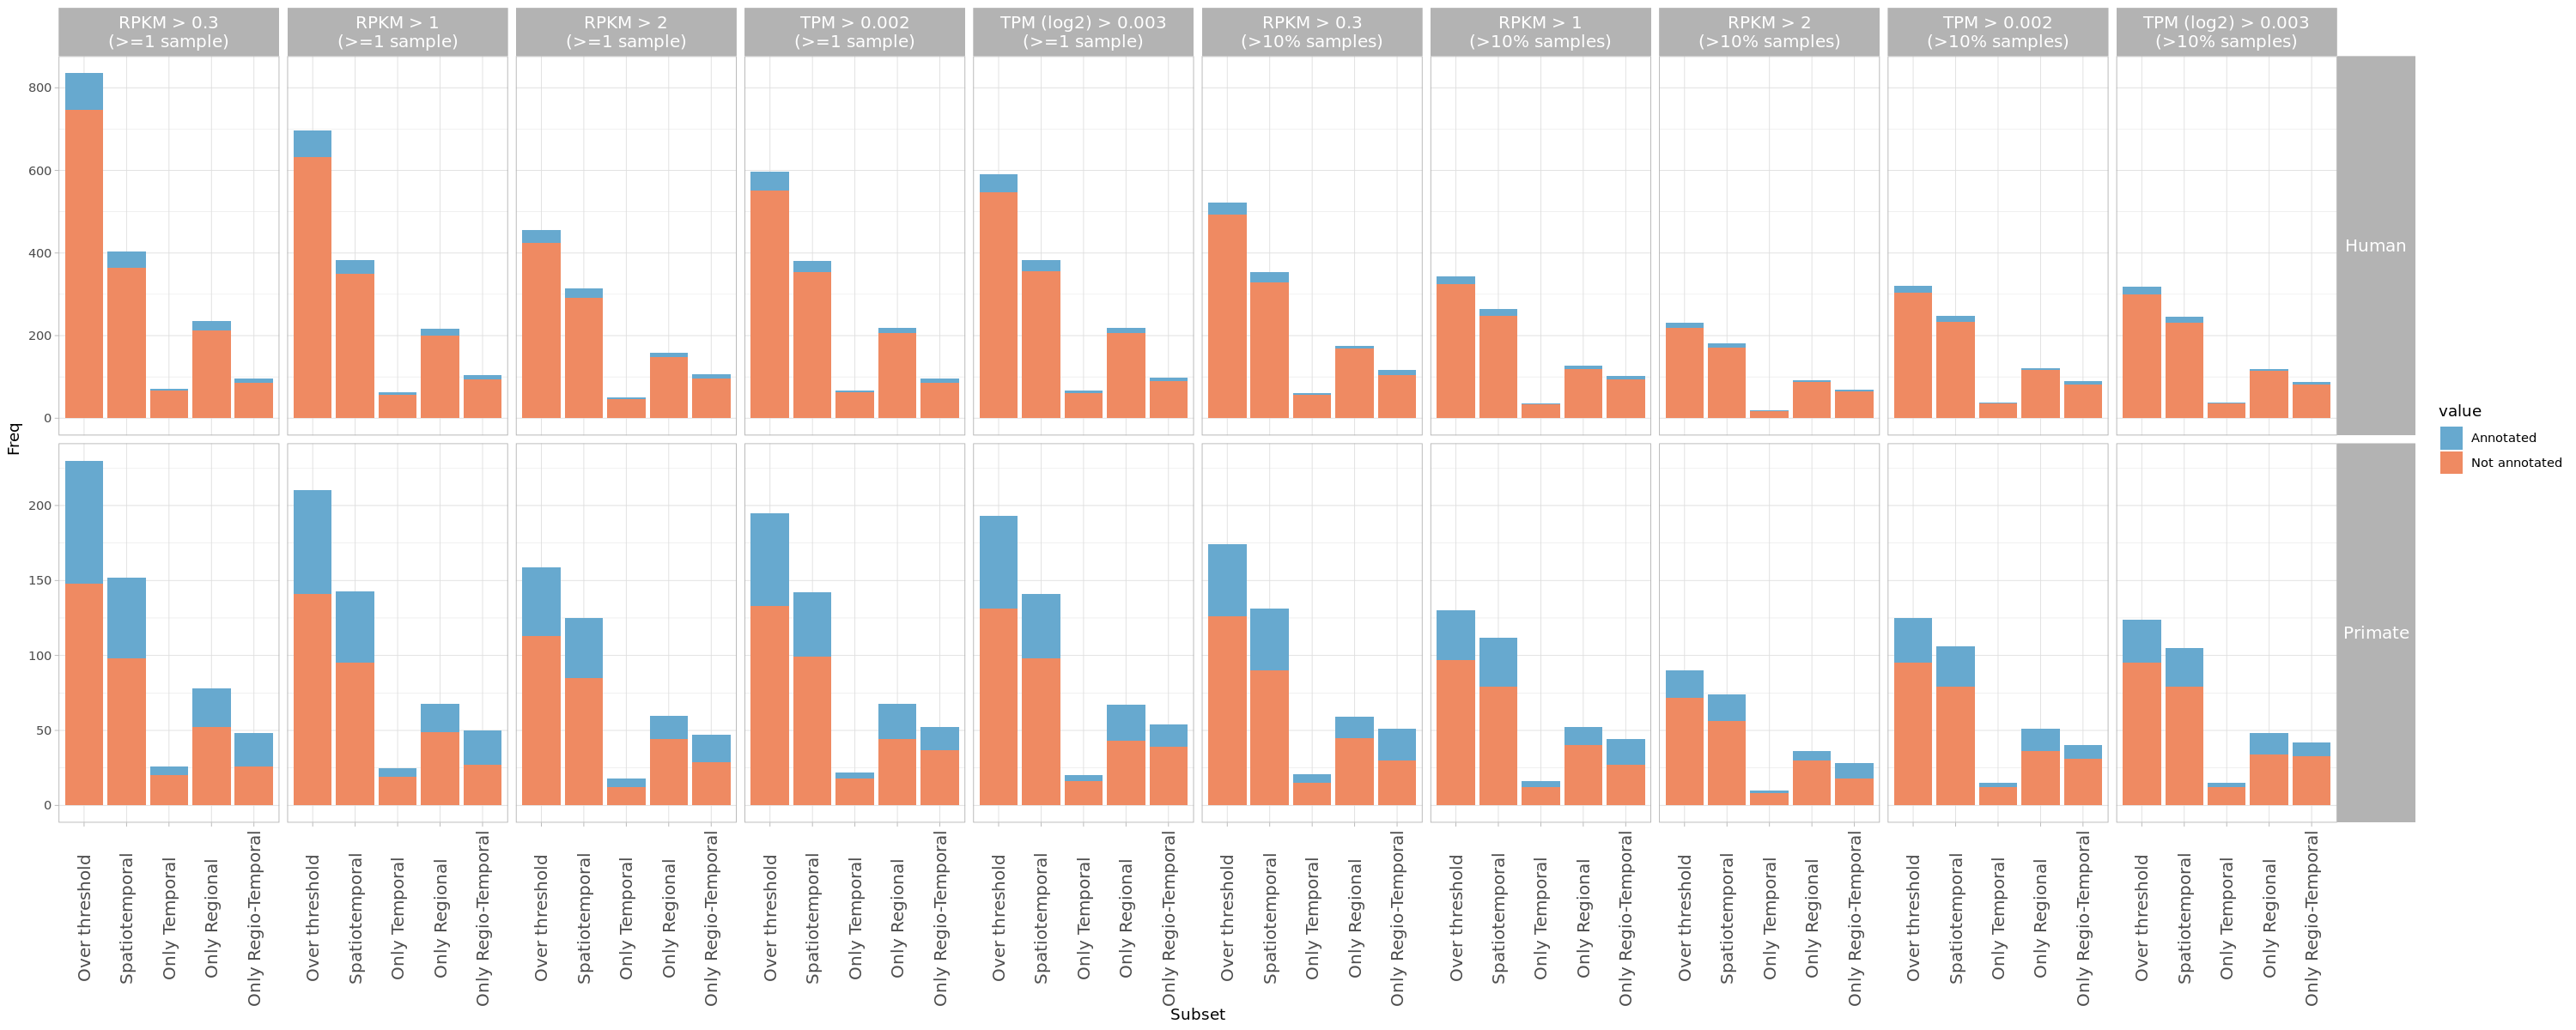

In [43]:
if (summary.plots.opt){
    summary_plot
}

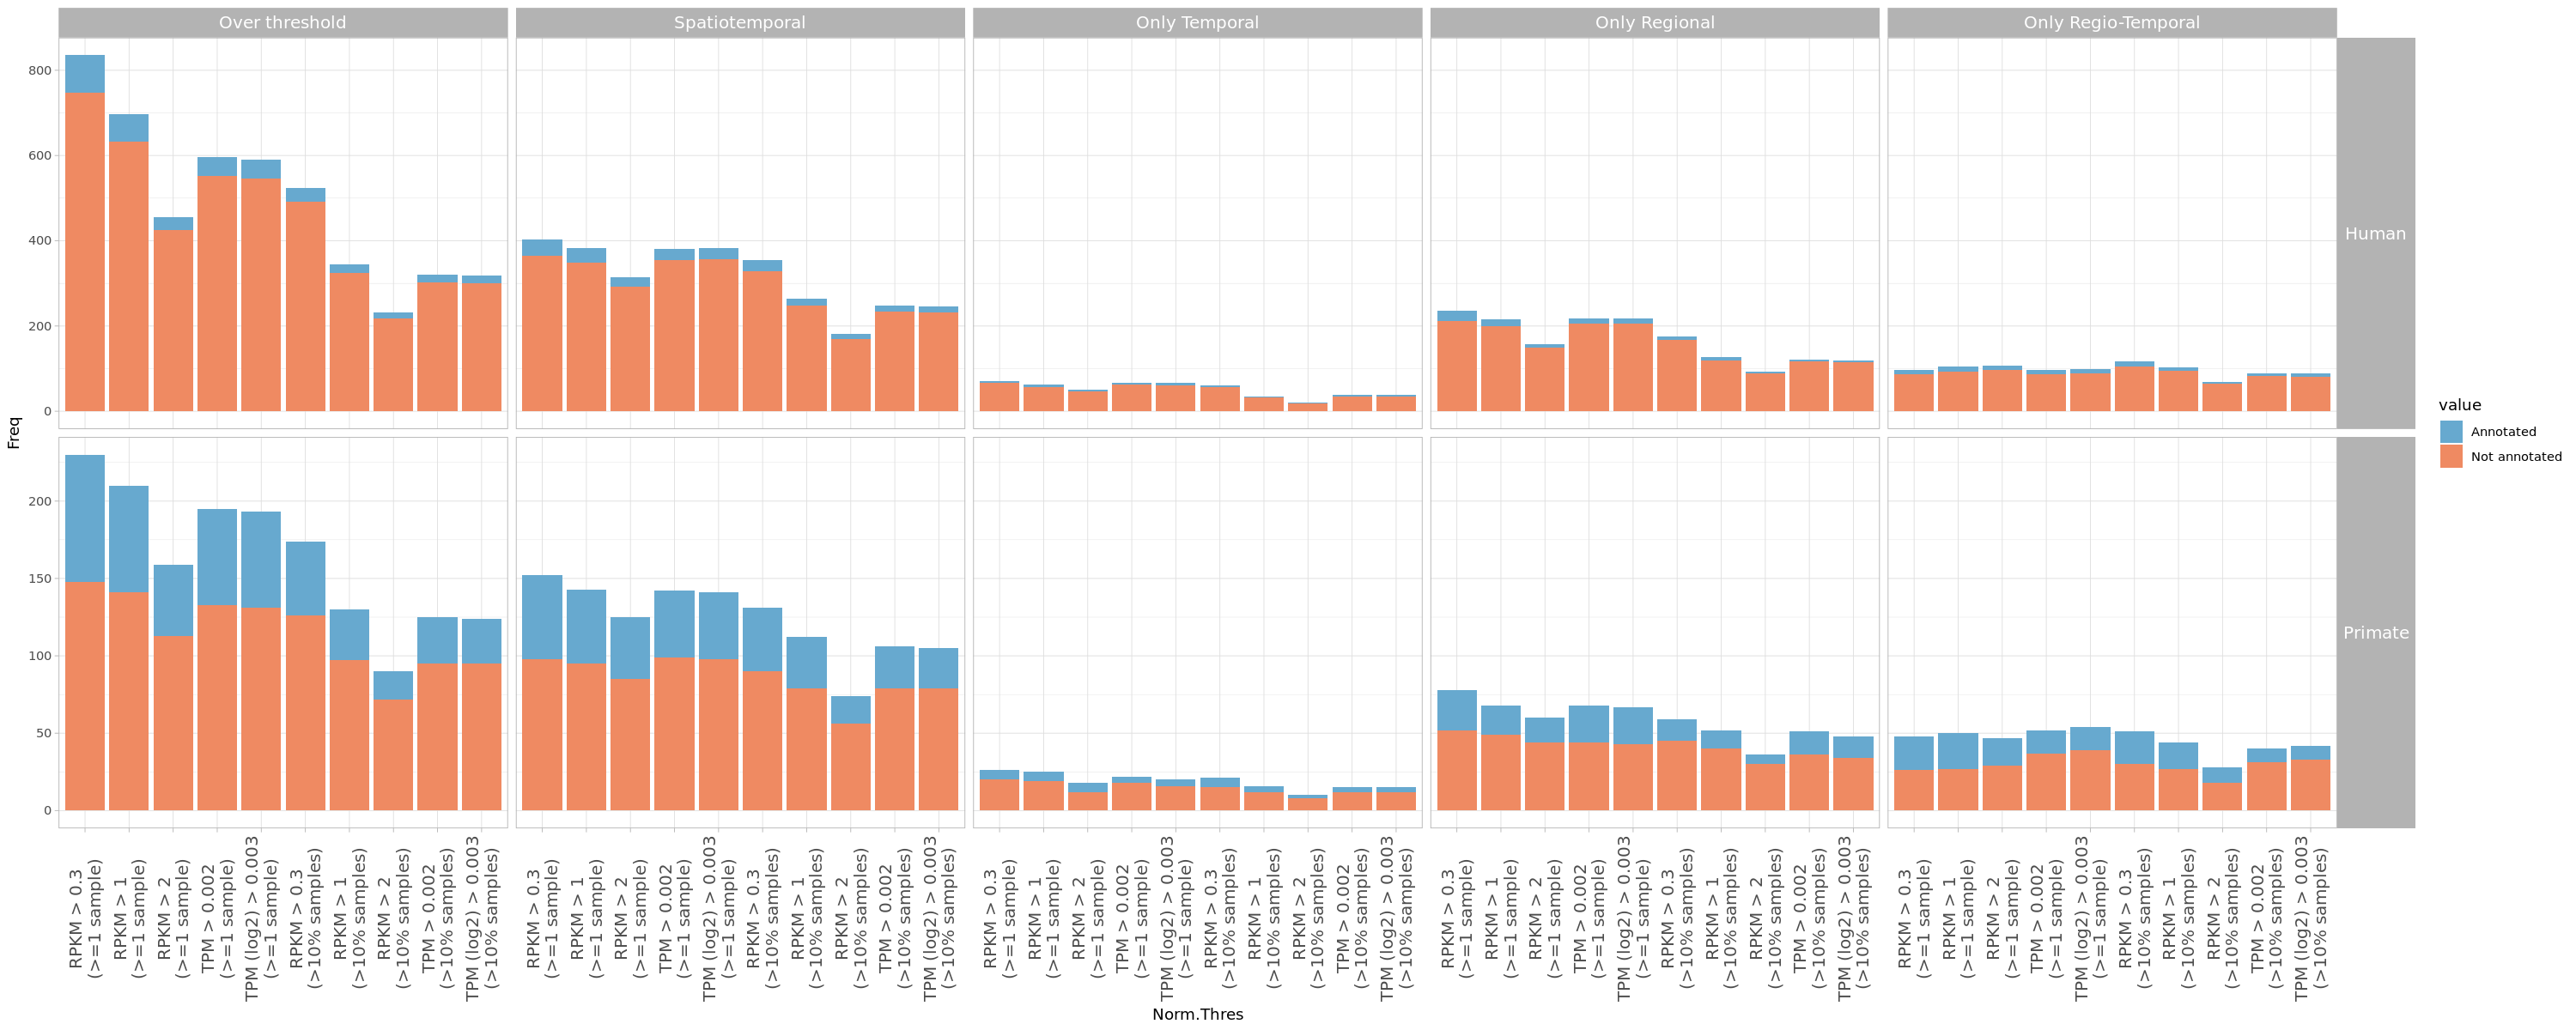

In [44]:
if (summary.plots.opt){
    summary_plot_alt
}